In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import re
import string
from string import punctuation
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMModel,LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

stop_words = set(stopwords.words('english'))
punctuation = punctuation + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

### 모르는 라이브러리 설명

- [textblob](https://statkclee.github.io/nlp2/nlp-textblob.html)
- [nltk](https://datascienceschool.net/03%20machine%20learning/03.01.01%20NLTK%20%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html)
- [xgboost](https://dining-developer.tistory.com/3)
- [lightgbm](https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/)
- [catboost](https://dailyheumsi.tistory.com/136)

In [7]:
df_train = pd.read_csv('./input/drugsComTrain_raw.csv')
df_test = pd.read_csv('./input/drugsComTest_raw.csv')

print('train set: ', df_train.shape)
print('test set: ', df_test.shape)

train set:  (161297, 7)
test set:  (53766, 7)


In [9]:
# merging train and test

merge= [df_train, df_test]
df_data = pd.concat(merge)

print(df_data.shape)

df_data.head()

(215063, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [12]:
# 결측값 처리
print('Null values in the dataset: ', df_data.isnull().sum(axis=0))

# 코드는 안넣었지만 계산해보면 전체 데이터의 0.5%이므로 삭제해도 된다고 판단
df_data = df_data.dropna(how='any', axis=0)

print('data shape after null values removed : ', df_data.shape)

Null values in the dataset:  uniqueID          0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64
data shape after null values removed :  (213869, 7)


In [18]:
# 컬럼명을 소문자로 해서 쉽게 처리 하고 싶은듯
df_data.columns = df_data.columns.str.lower()

In [19]:
# 데이터 프레임 정렬
df_data.sort_values(['uniqueid'], ascending =True, inplace =True)
df_data.reset_index(drop = True, inplace = True)
df_data.head()

,uniqueid,drugname,condition,review,rating,date,usefulcount
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,28-Oct-15,4
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,27-Oct-15,11
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,27-Oct-15,7
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,26-Oct-15,12
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,25-Oct-15,4


In [21]:
# 전체 유니크 컨디션
print(df_data['condition'].nunique(), '\n')

print('some of the conditions are: ', df_data['condition'].unique()[0:10])

916 

some of the conditions are:  ['Abnormal Uterine Bleeding' 'Amenorrhea' 'Birth Control' 'Endometriosis'
 'Endometrial Hyperplasia, Prophylaxis' 'Renal Cell Carcinoma'
 'Not Listed / Othe' 'Eye Redness' 'Benign Prostatic Hyperplasia' 'Acne']


In [24]:
# 1점 받은 약 모음과 빈도 수
df_data.loc[df_data['rating'] == 1, :]['drugname'].value_counts()

Miconazole                           767
Ethinyl estradiol / norethindrone    728
Etonogestrel                         707
Levonorgestrel                       511
Nexplanon                            504
                                    ... 
Iron sucrose                           1
Acetaminophen / pamabrom               1
Betapace AF                            1
Balziva                                1
Zenzedi                                1
Name: drugname, Length: 1916, dtype: int64

In [23]:
# 리뷰 추천 0개
df_data.loc[df_data.usefulcount ==0, 'drugname'].value_counts()

Etonogestrel                         590
Levonorgestrel                       473
Ethinyl estradiol / norethindrone    371
Implanon                             327
Ethinyl estradiol / norgestimate     252
                                    ... 
Succinylcholine                        1
Antihemophilic factor                  1
Calcium carbonate                      1
Sprycel                                1
Maxichlor PSE DM                       1
Name: drugname, Length: 1487, dtype: int64

In [25]:
# date컬럼은 타임 포맷으로
df_data['date']=pd.to_datetime(df_data['date'])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

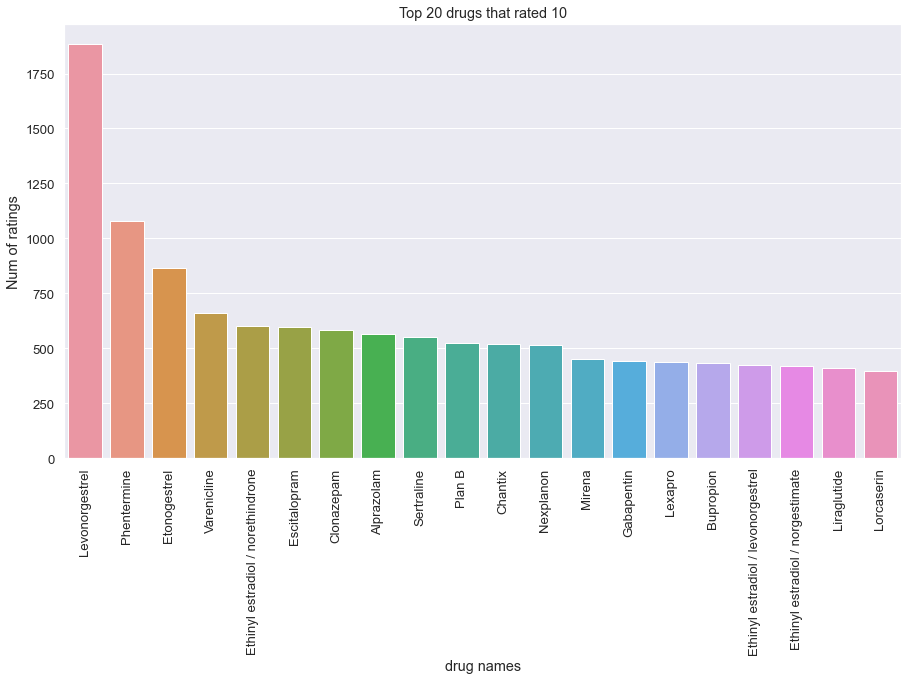

In [31]:
# 10점 받은 약 탑 20개 차트

sns.set(font_scale = 1.2, style ='darkgrid')
plt.rcParams['figure.figsize']=[15,8]

rating = dict(df_data.loc[df_data.rating == 10, 'drugname'].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set(title='Top 20 drugs that rated 10', ylabel = 'Num of ratings', xlabel='drug names')
plt.setp(sns_rating.get_xticklabels(), rotation=90)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

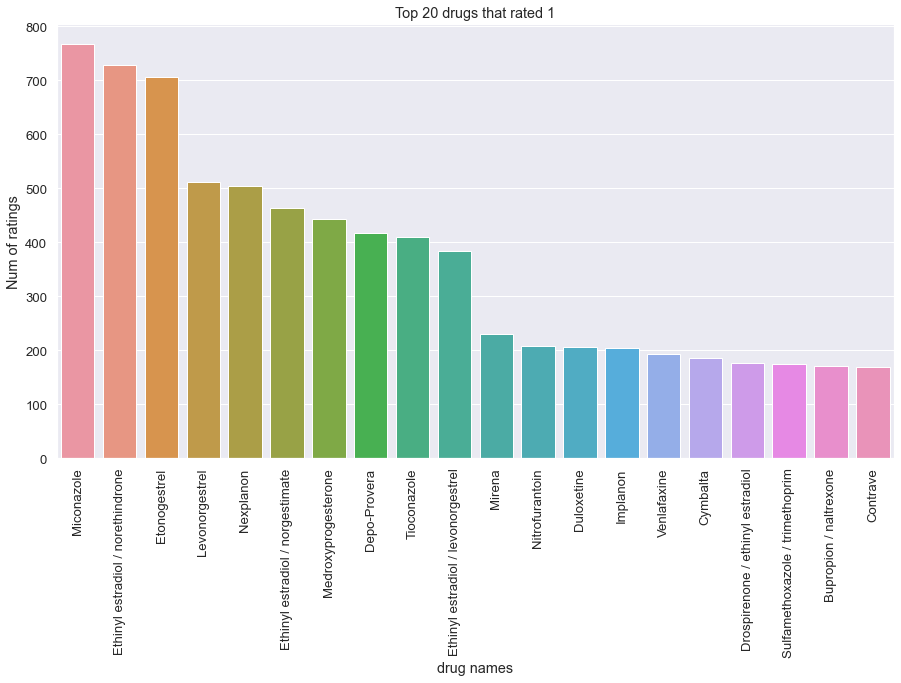

In [32]:
# 1점 받은 약 탑 20 차트

sns.set(font_scale = 1.2, style ='darkgrid')
plt.rcParams['figure.figsize']=[15,8]

rating = dict(df_data.loc[df_data.rating == 1, 'drugname'].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set(title='Top 20 drugs that rated 1', ylabel = 'Num of ratings', xlabel='drug names')
plt.setp(sns_rating.get_xticklabels(), rotation=90)

Text(0.5, 0, 'rating')

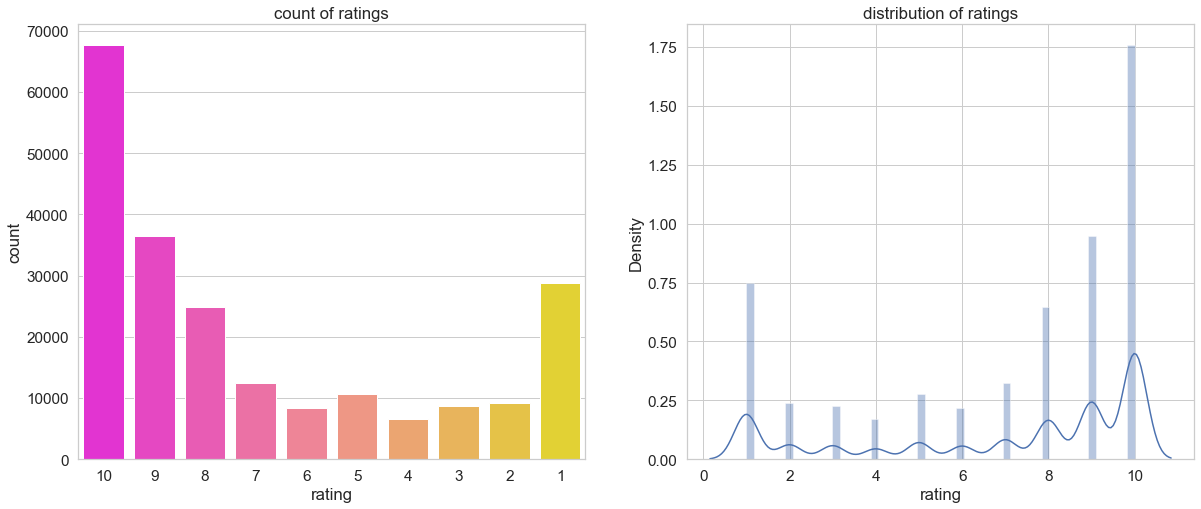

In [33]:
# 평점의 분포를 알기위한 차트

plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'whitegrid')
fig, ax = plt.subplots(1,2)

sns_1 = sns.countplot(df_data['rating'], palette='spring', order = list(range(10, 0, -1)), ax= ax[0])
sns_2 = sns.distplot(df_data['rating'], ax = ax[1])
sns_1.set_title('count of ratings')
sns_1.set_xlabel('rating')

sns_2.set_title('distribution of ratings')
sns_2.set_xlabel('rating')

(-0.5, 999.5, 499.5, -0.5)

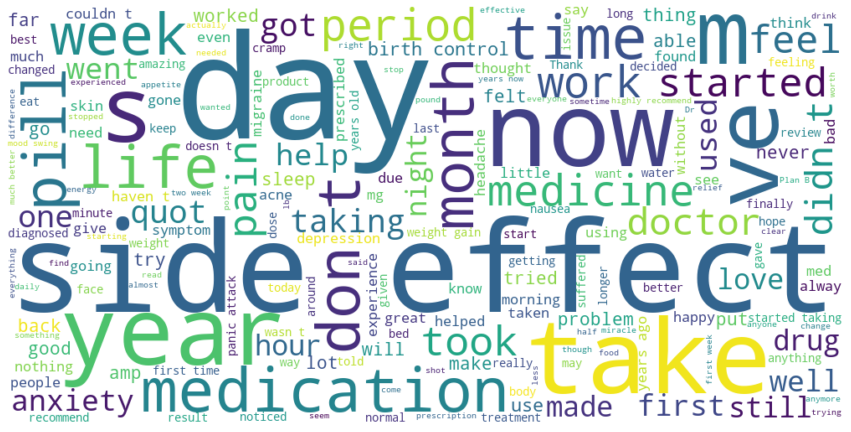

In [35]:
# 10점들의 리뷰 워드클라우드

df_rate_ten = df_data.loc[df_data.rating == 10, 'review']
k=(' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height =500, background_color = 'white').generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

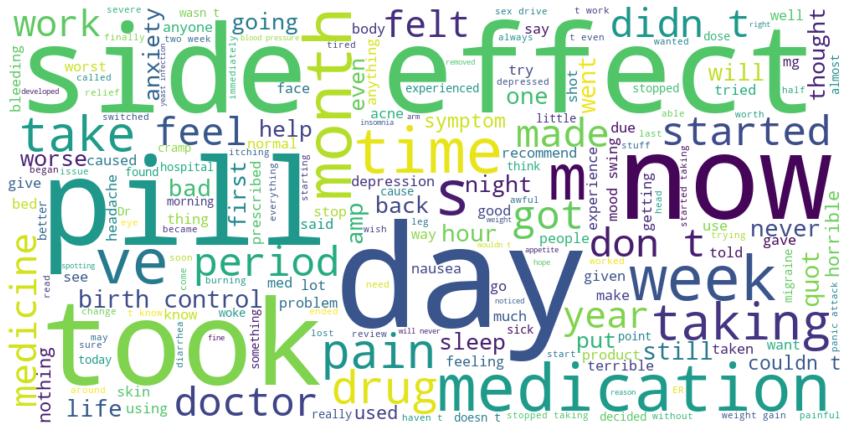

In [36]:
# 1점들의 리뷰 워드클라우드

df_rate_ten = df_data.loc[df_data.rating == 1, 'review']
k=(' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height =500, background_color = 'white').generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

Text(0, 0.5, 'count')

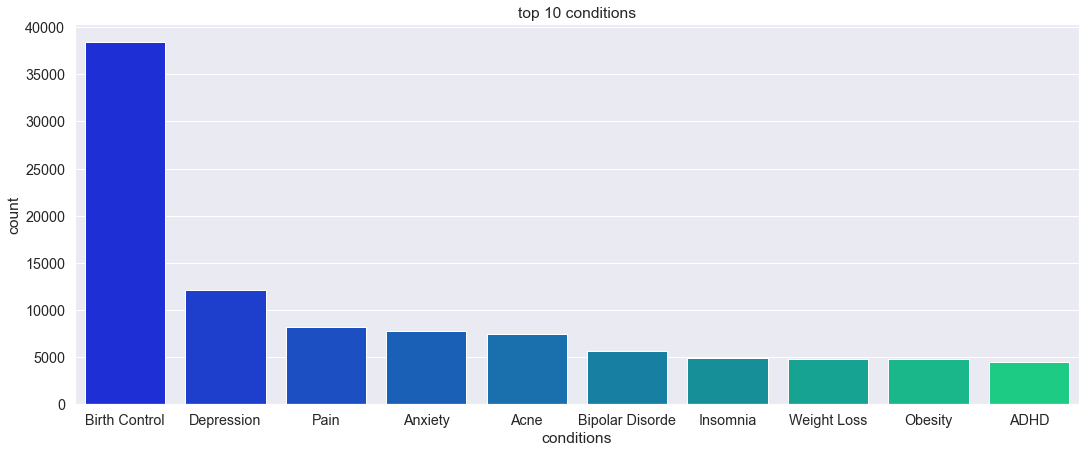

In [37]:
# 탑 10 증상

cond = dict(df_data['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style= 'darkgrid', font_scale= 1.3)
plt.rcParams['figure.figsize'] = [18,7]

sns_ = sns.barplot(x=top_condition, y=values, palette='winter')
sns_.set_title('top 10 conditions')
sns_.set_xlabel('conditions')
sns_.set_ylabel('count')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

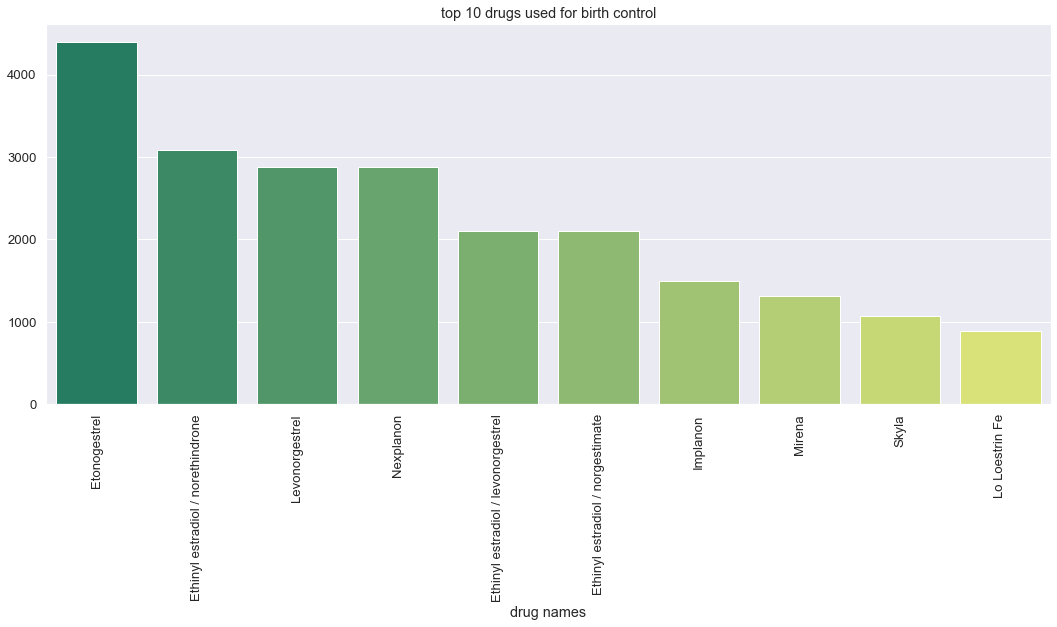

In [40]:
# 1등인 피임약에 대한 약

df = df_data[df_data['condition'] == 'Birth Control']['drugname'].value_counts()[0:10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x=df.index, y=df.values, palette='summer')
sns_.set_xlabel('drug names')
sns_.set_title('top 10 drugs used for birth control')
plt.setp(sns_.get_xticklabels(), rotation=90)

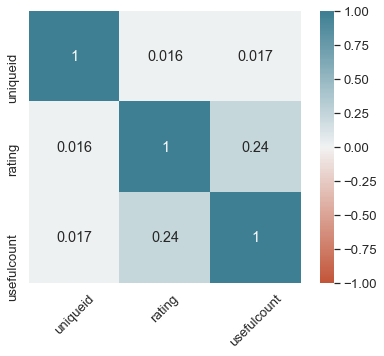

In [41]:
# 숫자 값이 uniqueid, rating, usefulcount 상관관계

plt.rcParams['figure.figsize'] = [7,5]
sns.set(font_scale = 1.2)
corr = df_data.select_dtypes(include = 'int64').corr()
sns_heat = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200), square=True);
plt.setp(sns_heat.get_xticklabels(), rotation = 45);

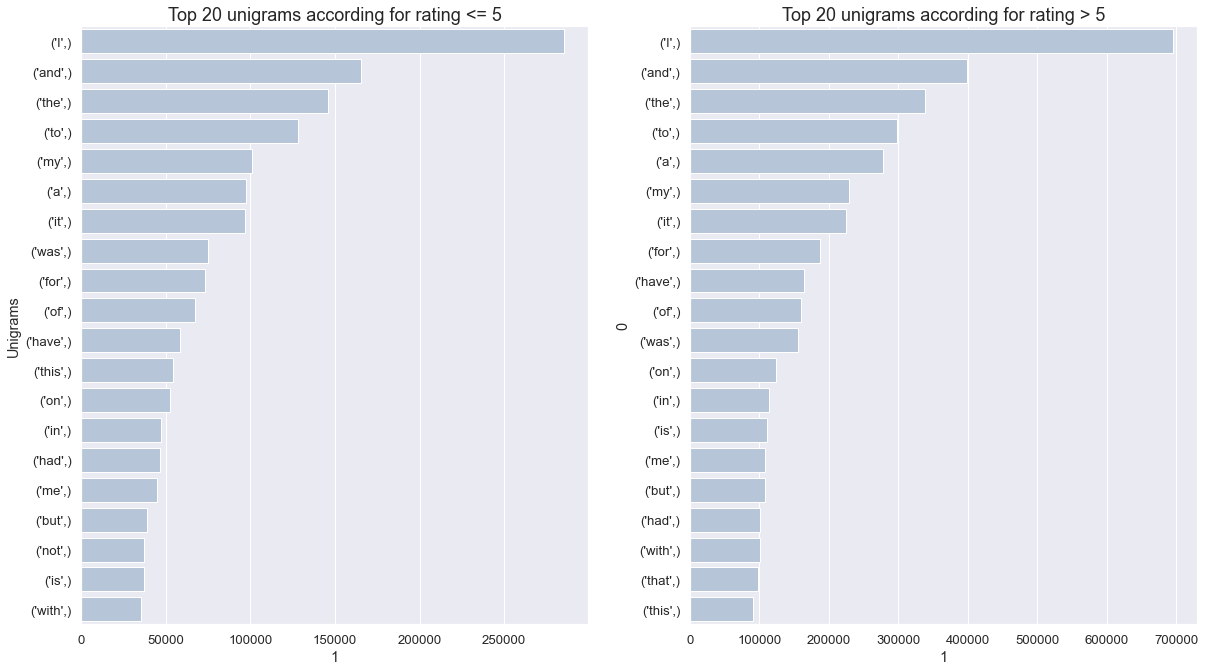

In [43]:
# 1단어 분석
# 먼저 단어를 나누고 빈도를 분석

df_ = df_data[['rating', 'review']]
df_['review'] = df_data['review'].str.replace("&#039;", "")
df_['review'] = df_['review'].str.replace(r'[^\w\d\s]',' ')

df_review_5 = " ".join(df_.loc[df_.rating <= 5, 'review'])
df_review_10 = " ".join(df_.loc[df_.rating > 5, 'review'])

token_review_5 = word_tokenize(df_review_5)
token_review_10 = word_tokenize(df_review_10)

unigrams_5 = ngrams(token_review_5, 1)
unigrams_10 = ngrams(token_review_10, 1)

frequency_5 = Counter(unigrams_5)
frequency_10 = Counter(unigrams_10)

df_5 = pd.DataFrame(frequency_5.most_common(20))
df_10 = pd.DataFrame(frequency_10.most_common(20))

# 차트
plt.rcParams['figure.figsize'] = [20,11]
fig, ax = plt.subplots(1,2)
sns.set(font_scale = 1.5, style = 'whitegrid')

sns_5 = sns.barplot(x = df_5[1], y = df_5[0], color = 'lightsteelblue', ax = ax[0])
sns_10 = sns.barplot(x = df_10[1], y = df_10[0], color = 'lightsteelblue', ax = ax[1])

# 축 설정
sns_5.set_title("Top 20 unigrams according for rating <= 5")
sns_10.set_title("Top 20 unigrams according for rating > 5")
sns_5.set_ylabel("Unigrams");

### 한 단어 분석으로는 차이가 없음을 알 수 있음

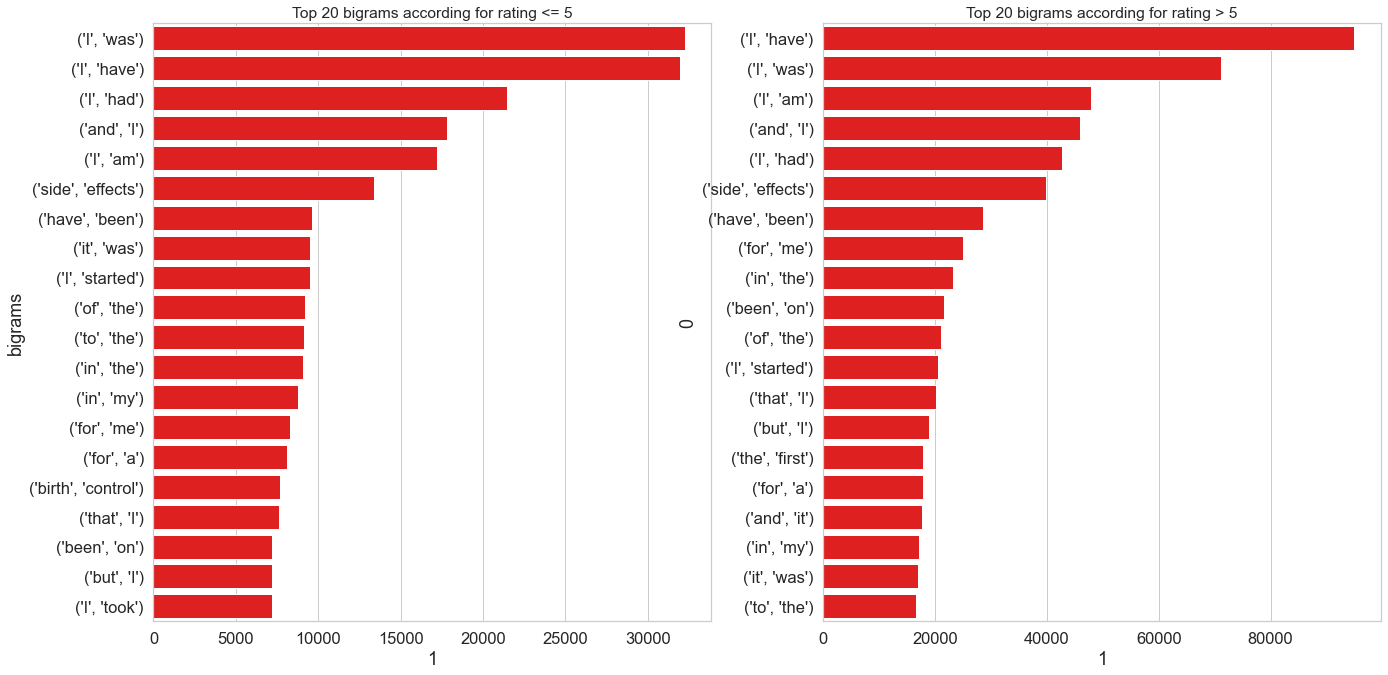

In [44]:
# 두 단어로 나눠서 빈도 분석
bigrams_5 = ngrams(token_review_5, 2)
bigrams_10 = ngrams(token_review_10, 2)

frequency_5 = Counter(bigrams_5)
frequency_10 = Counter(bigrams_10)

df_5 = pd.DataFrame(frequency_5.most_common(20))
df_10 = pd.DataFrame(frequency_10.most_common(20))

# 두단어 차트
plt.rcParams['figure.figsize'] = [22,11]
fig, ax = plt.subplots(1,2)
sns.set(font_scale = 1.3, style = 'whitegrid')

sns_5 = sns.barplot(x = df_5[1], y = df_5[0], color = 'red', ax = ax[0])
sns_10 = sns.barplot(x = df_10[1], y = df_10[0], color = 'red', ax = ax[1])

# 축 설정
sns_5.set_title("Top 20 bigrams according for rating <= 5")
sns_10.set_title("Top 20 bigrams according for rating > 5")
sns_5.set_ylabel("bigrams");

### 두 단어 분석도 차이를 발견하기 힘듦

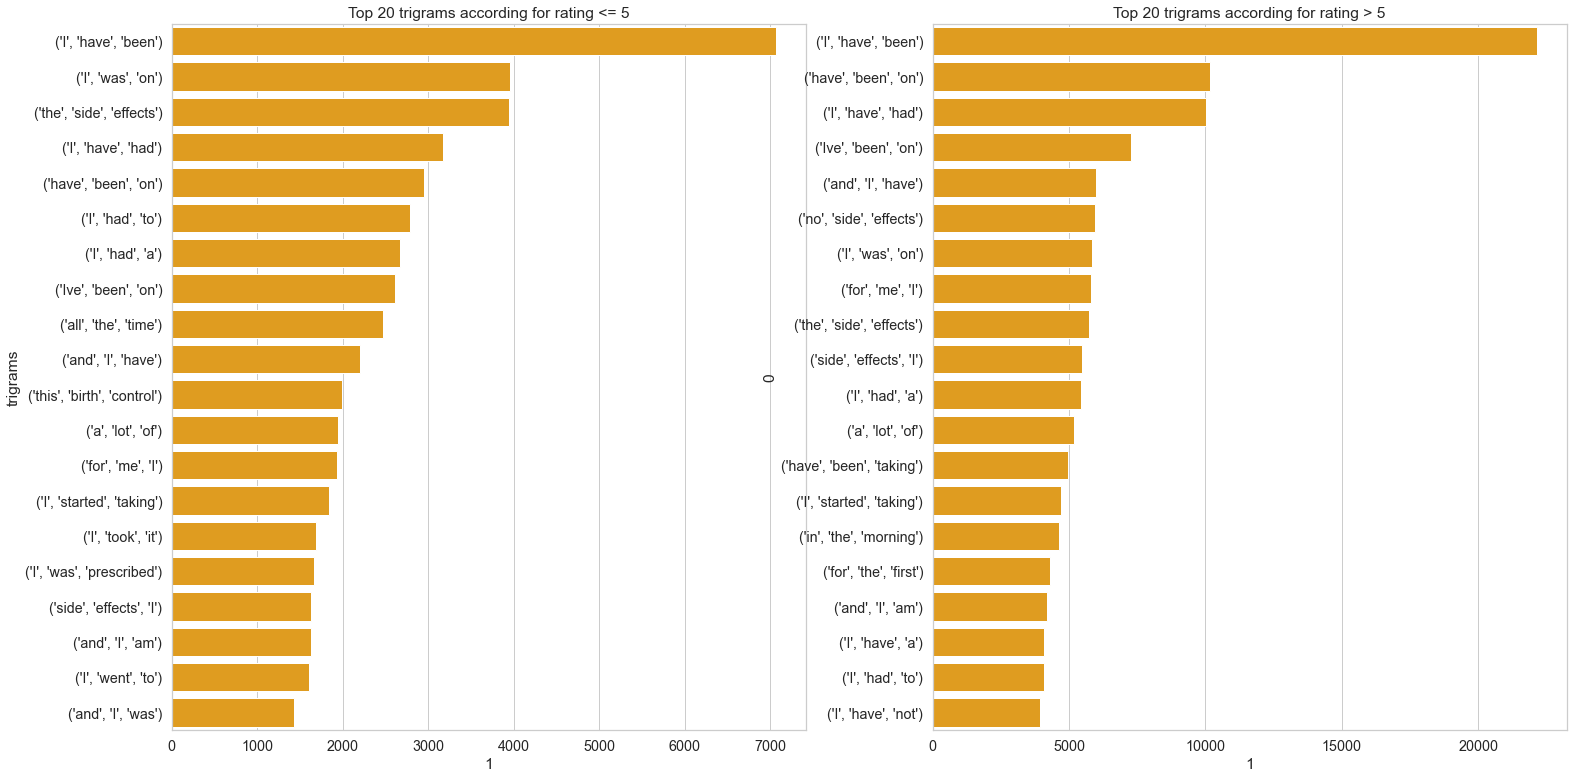

In [45]:
# 세 단어 분석
trigrams_5 = ngrams(token_review_5, 3)
trigrams_10 = ngrams(token_review_10, 3)

frequency_5 = Counter(trigrams_5)
frequency_10 = Counter(trigrams_10)

df_5 = pd.DataFrame(frequency_5.most_common(20))
df_10 = pd.DataFrame(frequency_10.most_common(20))


plt.rcParams['figure.figsize'] = [25,13]
fig, ax = plt.subplots(1,2)
sns.set(font_scale = 1.3, style = 'whitegrid')

sns_5 = sns.barplot(x = df_5[1], y = df_5[0], color = 'orange', ax = ax[0])
sns_10 = sns.barplot(x = df_10[1], y = df_10[0], color = 'orange', ax = ax[1])


sns_5.set_title("Top 20 trigrams according for rating <= 5")
sns_10.set_title("Top 20 trigrams according for rating > 5")
sns_5.set_ylabel("trigrams");

### 불용어가 너무 많다 -> 없애자!

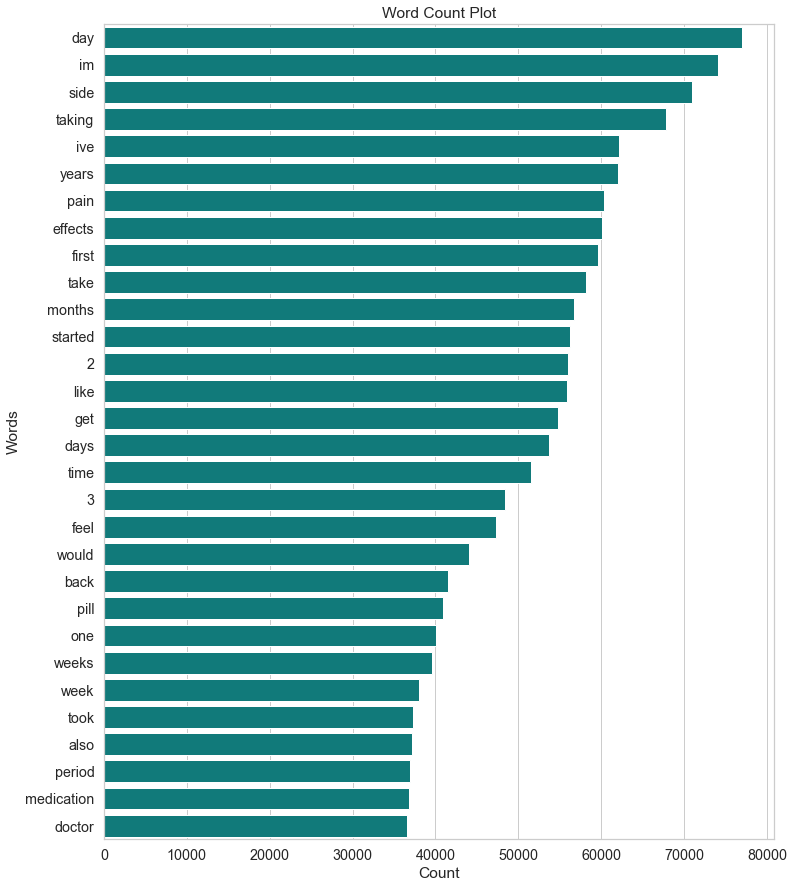

In [46]:
# Removing the stop words before plotting
stop_words = set(stopwords.words('english'))
df_['review'] = df_['review'].str.lower()
df_['review_1'] = df_['review'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
df_review = " ".join(df_['review_1'])
tokenize = word_tokenize(df_review)
frequency = Counter(tokenize)
df = pd.DataFrame(frequency.most_common(30))

plt.rcParams['figure.figsize'] = [12, 15]
sns.set(font_scale = 1.3, style = 'whitegrid')

# plotting
word_count = sns.barplot(x = df[1], y = df[0], color = 'darkcyan')
word_count.set_title("Word Count Plot")
word_count.set_ylabel("Words")
word_count.set_xlabel("Count");

In [47]:
# rating이 5점 초과면 1 외에는 0
df_data['sentiment_rate'] = df_data['rating'].apply(lambda x: 1 if x > 5 else 0)

In [48]:
def review_clean(review): 
    # 소문자 변환
    lower = review.str.lower()
    
    # ' 깨지는거 삭제
    pattern_remove = lower.str.replace("&#039;", "")
    
    # 이상한거 삭지
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    
    # 아스키 문자 삭제
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    
    # 공백에 붙어서 나오는 것들 삭제
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
    
    # 공백 두칸 이상인거 한칸으로
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
    
    # 점 여러개 하나로
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')
    
    return dataframe

In [49]:
# 축약어 풀기
contractions_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
    "doesn’t": "does not", "don't": "do not", "don’t": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
    "haven't": "have not", "he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
    "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
    "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not","might've": "might have",
    "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not","sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not","shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have",
    "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would",
    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y’all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have",
    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "ain’t": "am not", "aren’t": "are not",
    "can’t": "cannot", "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", "couldn’t": "could not", "couldn’t’ve": "could not have",
    "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
    "hasn’t": "has not", "haven’t": "have not", "he’d": "he had", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have",
    "he’s": "he is", "how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", "i’d": "i would", "i’d’ve": "i would have",
    "i’ll": "i will", "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would", "it’d’ve": "it would have",
    "it’ll": "it will", "it’ll’ve": "it will have", "it’s": "it is", "let’s": "let us", "ma’am": "madam", "mayn’t": "may not",
    "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not",
    "mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock","oughtn’t": "ought not", "oughtn’t’ve": "ought not have", "shan’t": "shall not", "sha’n’t": "shall not", "shan’t’ve": "shall not have",
    "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will", "she’ll’ve": "she will have", "she’s": "she is",
    "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have", "so’ve": "so have", "so’s": "so is",
    "that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would", "there’d’ve": "there would have",
    "there’s": "there is", "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will", "they’ll’ve": "they will have",
    "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would", "we’d’ve": "we would have",
    "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
    "what’ll’ve": "what will have", "what’re": "what are", "what’s": "what is", "what’ve": "what have", "when’s": "when is",
    "when’ve": "when have", "where’d": "where did", "where’s": "where is", "where’ve": "where have", "who’ll": "who will",
    "who’ll’ve": "who will have", "who’s": "who is", "who’ve": "who have","why’s": "why is", "why’ve": "why have", "will’ve": "will have",
    "won’t": "will not", "won’t’ve": "will not have", "would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have",
    "y’all": "you all", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have", "y’all’re": "you all are",
    "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have","you’re": "you are", "you’re": "you are", "you’ve": "you have"
}
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

In [50]:
# 리뷰 전처리
df_data['review_clean'] = review_clean(df_data['review'])

df_data['review_clean'] = df_data['review_clean'].apply(lambda x: expand_contractions(x))

df_data['review_clean'] = df_data['review_clean'].apply(lambda x: ''.join(word for word in x if word not in punctuation))


In [52]:
# Removing the stopwords
df_data['review_clean'] = df_data['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Removing the word stems using the Snowball Stemmer
Snow_ball = SnowballStemmer("english")
df_data['review_clean'] = df_data['review_clean'].apply(lambda x: " ".join(Snow_ball.stem(word) for word in x.split()))

df_data['review_clean'].head(5)

0    depo inject sinc januari 2015 bleed stop anoth...
1    im 21 year old recent found might pcos havent ...
2    shot 11 year month ago never 1 period even spo...
3    ive four shot point birth control pill year du...
4    total 3 shot got first one leav hospit give bi...
Name: review_clean, dtype: object

In [53]:
# Separating the day, month and year from the Date

df_data['day'] = df_data['date'].dt.day
df_data['month'] = df_data['date'].dt.month
df_data['year'] = df_data['date'].dt.year

df_data.head()


,uniqueid,drugname,condition,review,rating,date,usefulcount,sentiment_rate,review_clean,day,month,year
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,2015-10-28,4,0,depo inject sinc januari 2015 bleed stop anoth...,28,10,2015
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,2015-10-27,11,1,im 21 year old recent found might pcos havent ...,27,10,2015
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,2015-10-27,7,1,shot 11 year month ago never 1 period even spo...,27,10,2015
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,2015-10-26,12,1,ive four shot point birth control pill year du...,26,10,2015
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,2015-10-25,4,0,total 3 shot got first one leav hospit give bi...,25,10,2015


In [54]:
def sentiment(review):
    # Sentiment polarity of the reviews
    pol = []
    for i in review:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol

df_data['sentiment'] = sentiment(df_data['review'])

df_data['sentiment_clean'] = sentiment(df_data['review_clean'])



np.corrcoef(df_data['sentiment_clean'], df_data['rating'])

array([[1.        , 0.23328381],
       [0.23328381, 1.        ]])

In [55]:
np.corrcoef(df_data['sentiment'], df_data['rating'])

array([[1.       , 0.3481753],
       [0.3481753, 1.       ]])

### 클리닝 안한게 더 잘나옴

In [56]:
# 그래서 스톱워드랑 스테머 안하고 그냥 클리닝한 데이터를 사용할 예정

df_data['review_clean_ss'] = review_clean(df_data['review'])

df_data['review_clean_ss'] = df_data['review_clean_ss'].apply(lambda x: expand_contractions(x))

df_data['review_clean_ss'] = df_data['review_clean_ss'].apply(lambda x: ''.join(word for word in x if word not in punctuation))

df_data['sentiment_clean_ss'] = sentiment(df_data['review_clean_ss'])

In [57]:
np.corrcoef(df_data['sentiment_clean_ss'], df_data['rating'])

array([[1.        , 0.34600372],
       [0.34600372, 1.        ]])

In [58]:
#Word count in each review

df_data['count_word']=df_data["review_clean_ss"].apply(lambda x: len(str(x).split()))

#Unique word count 
df_data['count_unique_word']=df_data["review_clean_ss"].apply(lambda x: len(set(str(x).split())))

#Letter count
df_data['count_letters']=df_data["review_clean_ss"].apply(lambda x: len(str(x)))

#punctuation count
df_data["count_punctuations"] = df_data["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df_data["count_words_upper"] = df_data["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
df_data["count_words_title"] = df_data["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df_data["count_stopwords"] = df_data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

#Average length of the words
df_data["mean_word_len"] = df_data["review_clean_ss"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

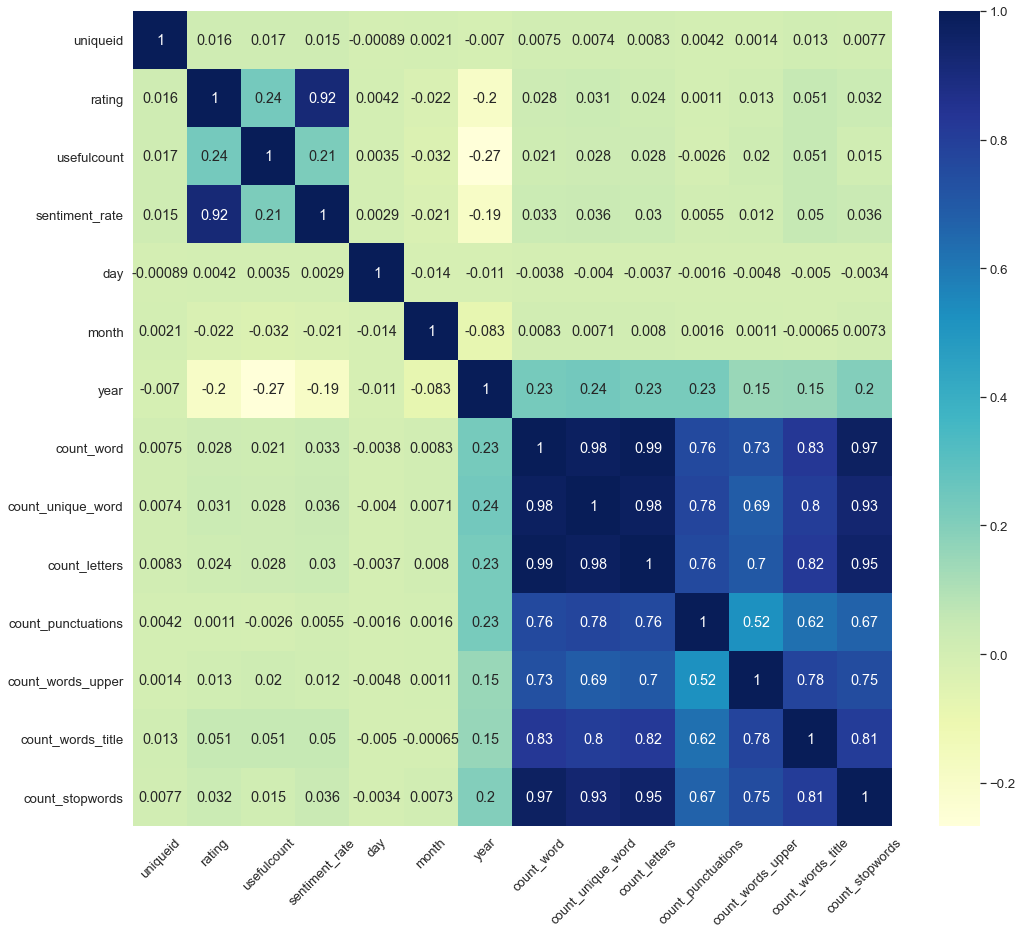

In [59]:
# Correlation Heatmap of the features engineered
plt.rcParams['figure.figsize'] = [17,15]
sns.set(font_scale = 1.2)
corr = df_data.select_dtypes(include = 'int64').corr()
sns_ = sns.heatmap(corr, annot = True, cmap = 'YlGnBu')
plt.setp(sns_.get_xticklabels(), rotation = 45);

In [60]:
# Label Encoding Drugname and Conditions
# 약과 증상을 머신러닝 하기위해 숫자형으로 인코딩
label_encoder_feat = {}
for feature in ['drugname', 'condition']:
    label_encoder_feat[feature] = LabelEncoder()
    df_data[feature] = label_encoder_feat[feature].fit_transform(df_data[feature])

In [61]:
# Defining Features and splitting the data as train and test set
# 리뷰의 단어 길이 개수 등등이랑 약이름 증상을 학습하기 위해 데이터셋 분할

features = df_data[['condition', 'usefulcount', 'sentiment', 'day', 'month', 'year',
                   'sentiment_clean_ss', 'count_word', 'count_unique_word', 'count_letters',
                   'count_punctuations', 'count_words_upper', 'count_words_title',
                   'count_stopwords', 'mean_word_len']]

target = df_data['sentiment_rate']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42)
print ("The Train set size ", X_train.shape)
print ("The Test set size ", X_test.shape)

The Train set size  (149708, 15)
The Test set size  (64161, 15)


In [62]:
# lightgbm사용해서 분류

clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
model = clf.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions), '\n')
print ("The confusion Matrix is \n")
print (confusion_matrix(y_test, predictions), '\n')

print (classification_report(y_test, predictions))

The Accuracy of the model is :  0.8876264397375353 

The confusion Matrix is 

[[14741  4604]
 [ 2606 42210]] 

              precision    recall  f1-score   support

           0       0.85      0.76      0.80     19345
           1       0.90      0.94      0.92     44816

    accuracy                           0.89     64161
   macro avg       0.88      0.85      0.86     64161
weighted avg       0.89      0.89      0.89     64161



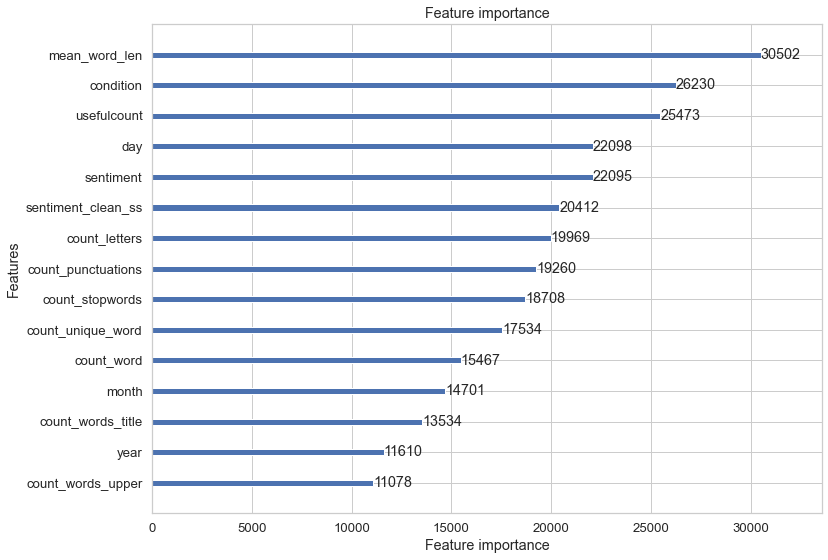

In [63]:
# Feature Importance Plot using LGBM
plt.rcParams['figure.figsize'] = [12, 9]
sns.set(style = 'whitegrid', font_scale = 1.2)
plot_importance(model);

In [64]:
# Training Model - II XGBOOST

xgb_clf = XGBClassifier(n_estimator = 10000,
                    learning_rate=0.10,
                    num_leaves=30)

model_xgb = xgb_clf.fit(X_train, y_train)

# Predictions
predictions_2 = model_xgb.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions_2), '\n')
print ("The confusion Matrix is \n")
print (confusion_matrix(y_test, predictions_2), '\n')

print (classification_report(y_test, predictions_2))

[02:09:10] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:09:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The Accuracy of the model is :  0.7677093561509328 

The confusion Matrix is 

[[ 8099 11246]
 [ 3658 41158]] 

              precision    recall  f1-score   support

           0       0.69      0.42      0.52     19345
           1       0.79      0.92      0.85     44816

    accuracy                           0.77     64161
   macro avg       0.74      0.67      0.68     64161
weighted avg       0.

### XGBOOST는 정확도가 셋중 가장 낮게 나옴

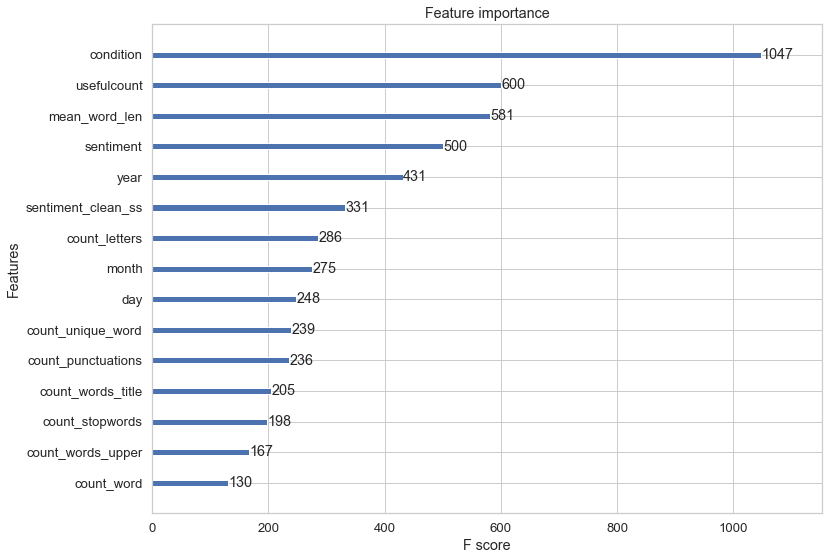

In [65]:
# Feature Importance Plot using XGBClassifier
from xgboost import plot_importance # plot_importance for xgboost
plt.rcParams['figure.figsize'] = [12, 9]
plot_importance(model_xgb);

In [66]:
# Training Model - III CatBoost 사용

cat_clf = CatBoostClassifier(iterations = 10000,
                            learning_rate = 0.5);

model_cat = cat_clf.fit(X_train, y_train);

0:	learn: 0.5592639	total: 309ms	remaining: 51m 30s
1:	learn: 0.5270244	total: 369ms	remaining: 30m 42s
2:	learn: 0.5162923	total: 423ms	remaining: 23m 29s
3:	learn: 0.5102473	total: 484ms	remaining: 20m 9s
4:	learn: 0.5067517	total: 538ms	remaining: 17m 54s
5:	learn: 0.5044681	total: 589ms	remaining: 16m 20s
6:	learn: 0.5031948	total: 646ms	remaining: 15m 22s
7:	learn: 0.5015889	total: 700ms	remaining: 14m 34s
8:	learn: 0.5003570	total: 756ms	remaining: 13m 59s
9:	learn: 0.4980368	total: 813ms	remaining: 13m 32s
10:	learn: 0.4968744	total: 852ms	remaining: 12m 53s
11:	learn: 0.4962453	total: 894ms	remaining: 12m 24s
12:	learn: 0.4957343	total: 939ms	remaining: 12m 1s
13:	learn: 0.4950683	total: 984ms	remaining: 11m 42s
14:	learn: 0.4935564	total: 1.03s	remaining: 11m 29s
15:	learn: 0.4923019	total: 1.09s	remaining: 11m 18s
16:	learn: 0.4915507	total: 1.14s	remaining: 11m 10s
17:	learn: 0.4909723	total: 1.21s	remaining: 11m 10s
18:	learn: 0.4905475	total: 1.27s	remaining: 11m 5s
19:	le

160:	learn: 0.4353606	total: 9s	remaining: 9m 10s
161:	learn: 0.4350542	total: 9.06s	remaining: 9m 10s
162:	learn: 0.4347214	total: 9.1s	remaining: 9m 9s
163:	learn: 0.4344764	total: 9.15s	remaining: 9m 8s
164:	learn: 0.4342974	total: 9.2s	remaining: 9m 8s
165:	learn: 0.4340601	total: 9.25s	remaining: 9m 7s
166:	learn: 0.4336988	total: 9.3s	remaining: 9m 7s
167:	learn: 0.4333300	total: 9.36s	remaining: 9m 7s
168:	learn: 0.4330580	total: 9.42s	remaining: 9m 7s
169:	learn: 0.4328373	total: 9.48s	remaining: 9m 7s
170:	learn: 0.4326081	total: 9.53s	remaining: 9m 7s
171:	learn: 0.4323627	total: 9.59s	remaining: 9m 7s
172:	learn: 0.4321086	total: 9.64s	remaining: 9m 7s
173:	learn: 0.4319238	total: 9.7s	remaining: 9m 7s
174:	learn: 0.4317292	total: 9.76s	remaining: 9m 7s
175:	learn: 0.4315327	total: 9.8s	remaining: 9m 6s
176:	learn: 0.4313145	total: 9.85s	remaining: 9m 6s
177:	learn: 0.4310846	total: 9.91s	remaining: 9m 6s
178:	learn: 0.4307655	total: 9.97s	remaining: 9m 7s
179:	learn: 0.4304

321:	learn: 0.3964225	total: 17.9s	remaining: 8m 58s
322:	learn: 0.3962407	total: 18s	remaining: 8m 58s
323:	learn: 0.3959898	total: 18s	remaining: 8m 58s
324:	learn: 0.3957661	total: 18.1s	remaining: 8m 58s
325:	learn: 0.3955569	total: 18.1s	remaining: 8m 58s
326:	learn: 0.3952321	total: 18.2s	remaining: 8m 58s
327:	learn: 0.3949855	total: 18.3s	remaining: 8m 58s
328:	learn: 0.3946920	total: 18.3s	remaining: 8m 58s
329:	learn: 0.3944648	total: 18.4s	remaining: 8m 58s
330:	learn: 0.3942556	total: 18.4s	remaining: 8m 58s
331:	learn: 0.3940048	total: 18.5s	remaining: 8m 58s
332:	learn: 0.3937389	total: 18.5s	remaining: 8m 58s
333:	learn: 0.3934790	total: 18.6s	remaining: 8m 58s
334:	learn: 0.3932774	total: 18.7s	remaining: 8m 58s
335:	learn: 0.3931132	total: 18.7s	remaining: 8m 58s
336:	learn: 0.3929826	total: 18.8s	remaining: 8m 58s
337:	learn: 0.3928590	total: 18.8s	remaining: 8m 58s
338:	learn: 0.3927097	total: 18.9s	remaining: 8m 57s
339:	learn: 0.3924480	total: 18.9s	remaining: 8m 5

480:	learn: 0.3638985	total: 26.7s	remaining: 8m 47s
481:	learn: 0.3636699	total: 26.7s	remaining: 8m 47s
482:	learn: 0.3634401	total: 26.8s	remaining: 8m 47s
483:	learn: 0.3632675	total: 26.8s	remaining: 8m 47s
484:	learn: 0.3631200	total: 26.9s	remaining: 8m 47s
485:	learn: 0.3629110	total: 27s	remaining: 8m 47s
486:	learn: 0.3627148	total: 27s	remaining: 8m 47s
487:	learn: 0.3625858	total: 27.1s	remaining: 8m 47s
488:	learn: 0.3624681	total: 27.1s	remaining: 8m 47s
489:	learn: 0.3622519	total: 27.1s	remaining: 8m 46s
490:	learn: 0.3620273	total: 27.2s	remaining: 8m 46s
491:	learn: 0.3618467	total: 27.2s	remaining: 8m 46s
492:	learn: 0.3616193	total: 27.3s	remaining: 8m 46s
493:	learn: 0.3614107	total: 27.4s	remaining: 8m 46s
494:	learn: 0.3612598	total: 27.4s	remaining: 8m 46s
495:	learn: 0.3611704	total: 27.5s	remaining: 8m 46s
496:	learn: 0.3610233	total: 27.5s	remaining: 8m 45s
497:	learn: 0.3607586	total: 27.6s	remaining: 8m 45s
498:	learn: 0.3606276	total: 27.6s	remaining: 8m 4

636:	learn: 0.3361235	total: 35.5s	remaining: 8m 42s
637:	learn: 0.3359459	total: 35.6s	remaining: 8m 42s
638:	learn: 0.3357535	total: 35.7s	remaining: 8m 42s
639:	learn: 0.3355704	total: 35.7s	remaining: 8m 42s
640:	learn: 0.3354695	total: 35.8s	remaining: 8m 42s
641:	learn: 0.3353366	total: 35.9s	remaining: 8m 42s
642:	learn: 0.3351005	total: 35.9s	remaining: 8m 42s
643:	learn: 0.3349838	total: 36s	remaining: 8m 42s
644:	learn: 0.3347443	total: 36s	remaining: 8m 42s
645:	learn: 0.3345895	total: 36.1s	remaining: 8m 42s
646:	learn: 0.3343710	total: 36.2s	remaining: 8m 42s
647:	learn: 0.3341966	total: 36.2s	remaining: 8m 42s
648:	learn: 0.3340343	total: 36.3s	remaining: 8m 42s
649:	learn: 0.3339131	total: 36.4s	remaining: 8m 42s
650:	learn: 0.3337917	total: 36.4s	remaining: 8m 43s
651:	learn: 0.3336623	total: 36.5s	remaining: 8m 43s
652:	learn: 0.3335130	total: 36.6s	remaining: 8m 43s
653:	learn: 0.3333340	total: 36.6s	remaining: 8m 43s
654:	learn: 0.3331252	total: 36.7s	remaining: 8m 4

795:	learn: 0.3120715	total: 45s	remaining: 8m 40s
796:	learn: 0.3119123	total: 45.1s	remaining: 8m 40s
797:	learn: 0.3117653	total: 45.1s	remaining: 8m 40s
798:	learn: 0.3116738	total: 45.2s	remaining: 8m 40s
799:	learn: 0.3116091	total: 45.2s	remaining: 8m 40s
800:	learn: 0.3114932	total: 45.3s	remaining: 8m 40s
801:	learn: 0.3112742	total: 45.4s	remaining: 8m 40s
802:	learn: 0.3111585	total: 45.4s	remaining: 8m 40s
803:	learn: 0.3110065	total: 45.5s	remaining: 8m 40s
804:	learn: 0.3108501	total: 45.5s	remaining: 8m 40s
805:	learn: 0.3107786	total: 45.6s	remaining: 8m 40s
806:	learn: 0.3105708	total: 45.7s	remaining: 8m 40s
807:	learn: 0.3104559	total: 45.7s	remaining: 8m 40s
808:	learn: 0.3103092	total: 45.8s	remaining: 8m 40s
809:	learn: 0.3101605	total: 45.8s	remaining: 8m 40s
810:	learn: 0.3099931	total: 45.9s	remaining: 8m 40s
811:	learn: 0.3097868	total: 46s	remaining: 8m 40s
812:	learn: 0.3096336	total: 46s	remaining: 8m 39s
813:	learn: 0.3094787	total: 46.1s	remaining: 8m 39s

952:	learn: 0.2889585	total: 53.8s	remaining: 8m 30s
953:	learn: 0.2888155	total: 53.8s	remaining: 8m 30s
954:	learn: 0.2887302	total: 53.9s	remaining: 8m 30s
955:	learn: 0.2886547	total: 53.9s	remaining: 8m 30s
956:	learn: 0.2885094	total: 54s	remaining: 8m 30s
957:	learn: 0.2883708	total: 54.1s	remaining: 8m 30s
958:	learn: 0.2882411	total: 54.1s	remaining: 8m 30s
959:	learn: 0.2881307	total: 54.2s	remaining: 8m 29s
960:	learn: 0.2880508	total: 54.2s	remaining: 8m 29s
961:	learn: 0.2878367	total: 54.3s	remaining: 8m 29s
962:	learn: 0.2876579	total: 54.3s	remaining: 8m 29s
963:	learn: 0.2875434	total: 54.4s	remaining: 8m 29s
964:	learn: 0.2874365	total: 54.4s	remaining: 8m 29s
965:	learn: 0.2873291	total: 54.5s	remaining: 8m 29s
966:	learn: 0.2872634	total: 54.5s	remaining: 8m 29s
967:	learn: 0.2871964	total: 54.6s	remaining: 8m 29s
968:	learn: 0.2869814	total: 54.6s	remaining: 8m 29s
969:	learn: 0.2868022	total: 54.7s	remaining: 8m 29s
970:	learn: 0.2866308	total: 54.8s	remaining: 8m

1108:	learn: 0.2684087	total: 1m 2s	remaining: 8m 18s
1109:	learn: 0.2682683	total: 1m 2s	remaining: 8m 17s
1110:	learn: 0.2681628	total: 1m 2s	remaining: 8m 17s
1111:	learn: 0.2680517	total: 1m 2s	remaining: 8m 17s
1112:	learn: 0.2679790	total: 1m 2s	remaining: 8m 17s
1113:	learn: 0.2678417	total: 1m 2s	remaining: 8m 17s
1114:	learn: 0.2676368	total: 1m 2s	remaining: 8m 17s
1115:	learn: 0.2675065	total: 1m 2s	remaining: 8m 17s
1116:	learn: 0.2673861	total: 1m 2s	remaining: 8m 17s
1117:	learn: 0.2672725	total: 1m 2s	remaining: 8m 17s
1118:	learn: 0.2671973	total: 1m 2s	remaining: 8m 17s
1119:	learn: 0.2670949	total: 1m 2s	remaining: 8m 17s
1120:	learn: 0.2669397	total: 1m 2s	remaining: 8m 17s
1121:	learn: 0.2668187	total: 1m 2s	remaining: 8m 17s
1122:	learn: 0.2667147	total: 1m 2s	remaining: 8m 17s
1123:	learn: 0.2666248	total: 1m 2s	remaining: 8m 16s
1124:	learn: 0.2665399	total: 1m 2s	remaining: 8m 16s
1125:	learn: 0.2664353	total: 1m 3s	remaining: 8m 16s
1126:	learn: 0.2662282	total

1262:	learn: 0.2497936	total: 1m 10s	remaining: 8m 8s
1263:	learn: 0.2497057	total: 1m 10s	remaining: 8m 8s
1264:	learn: 0.2495954	total: 1m 10s	remaining: 8m 8s
1265:	learn: 0.2495183	total: 1m 10s	remaining: 8m 8s
1266:	learn: 0.2493869	total: 1m 10s	remaining: 8m 8s
1267:	learn: 0.2492791	total: 1m 10s	remaining: 8m 8s
1268:	learn: 0.2491700	total: 1m 10s	remaining: 8m 8s
1269:	learn: 0.2491021	total: 1m 11s	remaining: 8m 8s
1270:	learn: 0.2490292	total: 1m 11s	remaining: 8m 8s
1271:	learn: 0.2489084	total: 1m 11s	remaining: 8m 8s
1272:	learn: 0.2488019	total: 1m 11s	remaining: 8m 7s
1273:	learn: 0.2486400	total: 1m 11s	remaining: 8m 7s
1274:	learn: 0.2485748	total: 1m 11s	remaining: 8m 7s
1275:	learn: 0.2485063	total: 1m 11s	remaining: 8m 7s
1276:	learn: 0.2483931	total: 1m 11s	remaining: 8m 7s
1277:	learn: 0.2482786	total: 1m 11s	remaining: 8m 7s
1278:	learn: 0.2481439	total: 1m 11s	remaining: 8m 7s
1279:	learn: 0.2480440	total: 1m 11s	remaining: 8m 7s
1280:	learn: 0.2479164	total

1415:	learn: 0.2331567	total: 1m 19s	remaining: 8m
1416:	learn: 0.2330759	total: 1m 19s	remaining: 8m
1417:	learn: 0.2329336	total: 1m 19s	remaining: 8m
1418:	learn: 0.2328414	total: 1m 19s	remaining: 7m 59s
1419:	learn: 0.2326712	total: 1m 19s	remaining: 7m 59s
1420:	learn: 0.2325898	total: 1m 19s	remaining: 7m 59s
1421:	learn: 0.2324747	total: 1m 19s	remaining: 7m 59s
1422:	learn: 0.2323481	total: 1m 19s	remaining: 7m 59s
1423:	learn: 0.2322621	total: 1m 19s	remaining: 7m 59s
1424:	learn: 0.2321493	total: 1m 19s	remaining: 7m 59s
1425:	learn: 0.2320163	total: 1m 19s	remaining: 7m 59s
1426:	learn: 0.2318995	total: 1m 19s	remaining: 7m 59s
1427:	learn: 0.2317888	total: 1m 19s	remaining: 7m 59s
1428:	learn: 0.2317246	total: 1m 19s	remaining: 7m 59s
1429:	learn: 0.2315708	total: 1m 20s	remaining: 7m 59s
1430:	learn: 0.2314517	total: 1m 20s	remaining: 7m 59s
1431:	learn: 0.2313596	total: 1m 20s	remaining: 7m 59s
1432:	learn: 0.2312765	total: 1m 20s	remaining: 7m 59s
1433:	learn: 0.2311620

1567:	learn: 0.2181293	total: 1m 27s	remaining: 7m 52s
1568:	learn: 0.2179930	total: 1m 27s	remaining: 7m 52s
1569:	learn: 0.2178411	total: 1m 27s	remaining: 7m 52s
1570:	learn: 0.2177135	total: 1m 28s	remaining: 7m 52s
1571:	learn: 0.2175725	total: 1m 28s	remaining: 7m 52s
1572:	learn: 0.2174929	total: 1m 28s	remaining: 7m 52s
1573:	learn: 0.2173951	total: 1m 28s	remaining: 7m 52s
1574:	learn: 0.2173255	total: 1m 28s	remaining: 7m 52s
1575:	learn: 0.2171836	total: 1m 28s	remaining: 7m 52s
1576:	learn: 0.2170072	total: 1m 28s	remaining: 7m 52s
1577:	learn: 0.2169038	total: 1m 28s	remaining: 7m 52s
1578:	learn: 0.2167971	total: 1m 28s	remaining: 7m 51s
1579:	learn: 0.2166563	total: 1m 28s	remaining: 7m 51s
1580:	learn: 0.2165728	total: 1m 28s	remaining: 7m 51s
1581:	learn: 0.2164563	total: 1m 28s	remaining: 7m 51s
1582:	learn: 0.2163845	total: 1m 28s	remaining: 7m 51s
1583:	learn: 0.2163013	total: 1m 28s	remaining: 7m 51s
1584:	learn: 0.2162096	total: 1m 28s	remaining: 7m 51s
1585:	lear

1717:	learn: 0.2038523	total: 1m 36s	remaining: 7m 42s
1718:	learn: 0.2037873	total: 1m 36s	remaining: 7m 42s
1719:	learn: 0.2037098	total: 1m 36s	remaining: 7m 42s
1720:	learn: 0.2036299	total: 1m 36s	remaining: 7m 42s
1721:	learn: 0.2035359	total: 1m 36s	remaining: 7m 42s
1722:	learn: 0.2034583	total: 1m 36s	remaining: 7m 42s
1723:	learn: 0.2033895	total: 1m 36s	remaining: 7m 42s
1724:	learn: 0.2033010	total: 1m 36s	remaining: 7m 42s
1725:	learn: 0.2031883	total: 1m 36s	remaining: 7m 42s
1726:	learn: 0.2031174	total: 1m 36s	remaining: 7m 42s
1727:	learn: 0.2030695	total: 1m 36s	remaining: 7m 42s
1728:	learn: 0.2029884	total: 1m 36s	remaining: 7m 42s
1729:	learn: 0.2028944	total: 1m 36s	remaining: 7m 42s
1730:	learn: 0.2028354	total: 1m 36s	remaining: 7m 42s
1731:	learn: 0.2027679	total: 1m 36s	remaining: 7m 42s
1732:	learn: 0.2026929	total: 1m 36s	remaining: 7m 42s
1733:	learn: 0.2025916	total: 1m 36s	remaining: 7m 42s
1734:	learn: 0.2025396	total: 1m 37s	remaining: 7m 42s
1735:	lear

1869:	learn: 0.1911340	total: 1m 44s	remaining: 7m 35s
1870:	learn: 0.1910327	total: 1m 44s	remaining: 7m 35s
1871:	learn: 0.1909315	total: 1m 44s	remaining: 7m 35s
1872:	learn: 0.1908371	total: 1m 44s	remaining: 7m 35s
1873:	learn: 0.1907641	total: 1m 44s	remaining: 7m 35s
1874:	learn: 0.1906447	total: 1m 45s	remaining: 7m 35s
1875:	learn: 0.1905899	total: 1m 45s	remaining: 7m 34s
1876:	learn: 0.1904797	total: 1m 45s	remaining: 7m 34s
1877:	learn: 0.1903922	total: 1m 45s	remaining: 7m 34s
1878:	learn: 0.1902327	total: 1m 45s	remaining: 7m 34s
1879:	learn: 0.1901452	total: 1m 45s	remaining: 7m 34s
1880:	learn: 0.1900383	total: 1m 45s	remaining: 7m 34s
1881:	learn: 0.1899571	total: 1m 45s	remaining: 7m 34s
1882:	learn: 0.1898609	total: 1m 45s	remaining: 7m 34s
1883:	learn: 0.1897945	total: 1m 45s	remaining: 7m 34s
1884:	learn: 0.1896936	total: 1m 45s	remaining: 7m 34s
1885:	learn: 0.1896036	total: 1m 45s	remaining: 7m 34s
1886:	learn: 0.1895217	total: 1m 45s	remaining: 7m 34s
1887:	lear

2021:	learn: 0.1790375	total: 1m 53s	remaining: 7m 27s
2022:	learn: 0.1789960	total: 1m 53s	remaining: 7m 27s
2023:	learn: 0.1789245	total: 1m 53s	remaining: 7m 27s
2024:	learn: 0.1788703	total: 1m 53s	remaining: 7m 27s
2025:	learn: 0.1788297	total: 1m 53s	remaining: 7m 27s
2026:	learn: 0.1787176	total: 1m 53s	remaining: 7m 27s
2027:	learn: 0.1786171	total: 1m 53s	remaining: 7m 27s
2028:	learn: 0.1785687	total: 1m 53s	remaining: 7m 27s
2029:	learn: 0.1785249	total: 1m 53s	remaining: 7m 27s
2030:	learn: 0.1784739	total: 1m 53s	remaining: 7m 27s
2031:	learn: 0.1783837	total: 1m 53s	remaining: 7m 26s
2032:	learn: 0.1782844	total: 1m 54s	remaining: 7m 26s
2033:	learn: 0.1782006	total: 1m 54s	remaining: 7m 26s
2034:	learn: 0.1781234	total: 1m 54s	remaining: 7m 26s
2035:	learn: 0.1780613	total: 1m 54s	remaining: 7m 26s
2036:	learn: 0.1779480	total: 1m 54s	remaining: 7m 26s
2037:	learn: 0.1778891	total: 1m 54s	remaining: 7m 26s
2038:	learn: 0.1777779	total: 1m 54s	remaining: 7m 26s
2039:	lear

2173:	learn: 0.1674672	total: 2m 2s	remaining: 7m 19s
2174:	learn: 0.1674117	total: 2m 2s	remaining: 7m 19s
2175:	learn: 0.1673228	total: 2m 2s	remaining: 7m 19s
2176:	learn: 0.1672561	total: 2m 2s	remaining: 7m 19s
2177:	learn: 0.1671827	total: 2m 2s	remaining: 7m 19s
2178:	learn: 0.1671104	total: 2m 2s	remaining: 7m 19s
2179:	learn: 0.1670492	total: 2m 2s	remaining: 7m 19s
2180:	learn: 0.1669800	total: 2m 2s	remaining: 7m 19s
2181:	learn: 0.1669005	total: 2m 2s	remaining: 7m 19s
2182:	learn: 0.1668391	total: 2m 2s	remaining: 7m 18s
2183:	learn: 0.1667903	total: 2m 2s	remaining: 7m 18s
2184:	learn: 0.1667096	total: 2m 2s	remaining: 7m 18s
2185:	learn: 0.1666071	total: 2m 2s	remaining: 7m 18s
2186:	learn: 0.1665096	total: 2m 2s	remaining: 7m 18s
2187:	learn: 0.1664562	total: 2m 2s	remaining: 7m 18s
2188:	learn: 0.1663780	total: 2m 2s	remaining: 7m 18s
2189:	learn: 0.1663252	total: 2m 2s	remaining: 7m 18s
2190:	learn: 0.1662578	total: 2m 3s	remaining: 7m 18s
2191:	learn: 0.1661314	total

2327:	learn: 0.1563129	total: 2m 10s	remaining: 7m 10s
2328:	learn: 0.1562502	total: 2m 10s	remaining: 7m 9s
2329:	learn: 0.1561636	total: 2m 10s	remaining: 7m 9s
2330:	learn: 0.1561293	total: 2m 10s	remaining: 7m 9s
2331:	learn: 0.1560566	total: 2m 10s	remaining: 7m 9s
2332:	learn: 0.1559805	total: 2m 10s	remaining: 7m 9s
2333:	learn: 0.1558859	total: 2m 10s	remaining: 7m 9s
2334:	learn: 0.1558371	total: 2m 10s	remaining: 7m 9s
2335:	learn: 0.1558021	total: 2m 10s	remaining: 7m 9s
2336:	learn: 0.1557410	total: 2m 10s	remaining: 7m 9s
2337:	learn: 0.1556939	total: 2m 11s	remaining: 7m 9s
2338:	learn: 0.1556312	total: 2m 11s	remaining: 7m 9s
2339:	learn: 0.1555890	total: 2m 11s	remaining: 7m 9s
2340:	learn: 0.1555343	total: 2m 11s	remaining: 7m 9s
2341:	learn: 0.1554625	total: 2m 11s	remaining: 7m 9s
2342:	learn: 0.1554027	total: 2m 11s	remaining: 7m 9s
2343:	learn: 0.1553364	total: 2m 11s	remaining: 7m 9s
2344:	learn: 0.1552403	total: 2m 11s	remaining: 7m 9s
2345:	learn: 0.1551783	tota

2480:	learn: 0.1463228	total: 2m 19s	remaining: 7m 1s
2481:	learn: 0.1462550	total: 2m 19s	remaining: 7m 1s
2482:	learn: 0.1461880	total: 2m 19s	remaining: 7m 1s
2483:	learn: 0.1461315	total: 2m 19s	remaining: 7m 1s
2484:	learn: 0.1460551	total: 2m 19s	remaining: 7m 1s
2485:	learn: 0.1460018	total: 2m 19s	remaining: 7m 1s
2486:	learn: 0.1459376	total: 2m 19s	remaining: 7m 1s
2487:	learn: 0.1458393	total: 2m 19s	remaining: 7m 1s
2488:	learn: 0.1457526	total: 2m 19s	remaining: 7m 1s
2489:	learn: 0.1456812	total: 2m 19s	remaining: 7m 1s
2490:	learn: 0.1456266	total: 2m 19s	remaining: 7m 1s
2491:	learn: 0.1455626	total: 2m 19s	remaining: 7m 1s
2492:	learn: 0.1455089	total: 2m 19s	remaining: 7m 1s
2493:	learn: 0.1454526	total: 2m 19s	remaining: 7m 1s
2494:	learn: 0.1454004	total: 2m 19s	remaining: 7m 1s
2495:	learn: 0.1453266	total: 2m 20s	remaining: 7m 1s
2496:	learn: 0.1452468	total: 2m 20s	remaining: 7m 1s
2497:	learn: 0.1451987	total: 2m 20s	remaining: 7m
2498:	learn: 0.1451018	total: 2

2632:	learn: 0.1368963	total: 2m 27s	remaining: 6m 53s
2633:	learn: 0.1368130	total: 2m 27s	remaining: 6m 53s
2634:	learn: 0.1367565	total: 2m 28s	remaining: 6m 53s
2635:	learn: 0.1367052	total: 2m 28s	remaining: 6m 53s
2636:	learn: 0.1366650	total: 2m 28s	remaining: 6m 53s
2637:	learn: 0.1366041	total: 2m 28s	remaining: 6m 53s
2638:	learn: 0.1365536	total: 2m 28s	remaining: 6m 53s
2639:	learn: 0.1365180	total: 2m 28s	remaining: 6m 53s
2640:	learn: 0.1364548	total: 2m 28s	remaining: 6m 53s
2641:	learn: 0.1364193	total: 2m 28s	remaining: 6m 53s
2642:	learn: 0.1363596	total: 2m 28s	remaining: 6m 53s
2643:	learn: 0.1362967	total: 2m 28s	remaining: 6m 53s
2644:	learn: 0.1362256	total: 2m 28s	remaining: 6m 53s
2645:	learn: 0.1361760	total: 2m 28s	remaining: 6m 53s
2646:	learn: 0.1361136	total: 2m 28s	remaining: 6m 53s
2647:	learn: 0.1360552	total: 2m 28s	remaining: 6m 52s
2648:	learn: 0.1360086	total: 2m 28s	remaining: 6m 52s
2649:	learn: 0.1359648	total: 2m 28s	remaining: 6m 52s
2650:	lear

2784:	learn: 0.1281697	total: 2m 36s	remaining: 6m 45s
2785:	learn: 0.1281093	total: 2m 36s	remaining: 6m 45s
2786:	learn: 0.1280680	total: 2m 36s	remaining: 6m 45s
2787:	learn: 0.1279890	total: 2m 36s	remaining: 6m 45s
2788:	learn: 0.1279016	total: 2m 36s	remaining: 6m 45s
2789:	learn: 0.1278471	total: 2m 36s	remaining: 6m 45s
2790:	learn: 0.1277960	total: 2m 36s	remaining: 6m 45s
2791:	learn: 0.1277261	total: 2m 36s	remaining: 6m 45s
2792:	learn: 0.1276740	total: 2m 36s	remaining: 6m 45s
2793:	learn: 0.1275948	total: 2m 37s	remaining: 6m 45s
2794:	learn: 0.1275080	total: 2m 37s	remaining: 6m 45s
2795:	learn: 0.1274418	total: 2m 37s	remaining: 6m 44s
2796:	learn: 0.1274028	total: 2m 37s	remaining: 6m 44s
2797:	learn: 0.1273486	total: 2m 37s	remaining: 6m 44s
2798:	learn: 0.1272854	total: 2m 37s	remaining: 6m 44s
2799:	learn: 0.1272404	total: 2m 37s	remaining: 6m 44s
2800:	learn: 0.1271725	total: 2m 37s	remaining: 6m 44s
2801:	learn: 0.1271074	total: 2m 37s	remaining: 6m 44s
2802:	lear

2935:	learn: 0.1202795	total: 2m 45s	remaining: 6m 37s
2936:	learn: 0.1202470	total: 2m 45s	remaining: 6m 37s
2937:	learn: 0.1201837	total: 2m 45s	remaining: 6m 37s
2938:	learn: 0.1201245	total: 2m 45s	remaining: 6m 37s
2939:	learn: 0.1200830	total: 2m 45s	remaining: 6m 37s
2940:	learn: 0.1200105	total: 2m 45s	remaining: 6m 37s
2941:	learn: 0.1199558	total: 2m 45s	remaining: 6m 36s
2942:	learn: 0.1199046	total: 2m 45s	remaining: 6m 36s
2943:	learn: 0.1198563	total: 2m 45s	remaining: 6m 36s
2944:	learn: 0.1198167	total: 2m 45s	remaining: 6m 36s
2945:	learn: 0.1197793	total: 2m 45s	remaining: 6m 36s
2946:	learn: 0.1197275	total: 2m 45s	remaining: 6m 36s
2947:	learn: 0.1196499	total: 2m 45s	remaining: 6m 36s
2948:	learn: 0.1195678	total: 2m 45s	remaining: 6m 36s
2949:	learn: 0.1195120	total: 2m 45s	remaining: 6m 36s
2950:	learn: 0.1194691	total: 2m 45s	remaining: 6m 36s
2951:	learn: 0.1193924	total: 2m 46s	remaining: 6m 36s
2952:	learn: 0.1193534	total: 2m 46s	remaining: 6m 36s
2953:	lear

3084:	learn: 0.1128532	total: 2m 53s	remaining: 6m 29s
3085:	learn: 0.1127815	total: 2m 53s	remaining: 6m 29s
3086:	learn: 0.1127422	total: 2m 53s	remaining: 6m 28s
3087:	learn: 0.1126633	total: 2m 53s	remaining: 6m 28s
3088:	learn: 0.1126138	total: 2m 53s	remaining: 6m 28s
3089:	learn: 0.1125615	total: 2m 53s	remaining: 6m 28s
3090:	learn: 0.1125008	total: 2m 53s	remaining: 6m 28s
3091:	learn: 0.1124468	total: 2m 53s	remaining: 6m 28s
3092:	learn: 0.1123991	total: 2m 54s	remaining: 6m 28s
3093:	learn: 0.1123606	total: 2m 54s	remaining: 6m 28s
3094:	learn: 0.1123062	total: 2m 54s	remaining: 6m 28s
3095:	learn: 0.1122799	total: 2m 54s	remaining: 6m 28s
3096:	learn: 0.1122312	total: 2m 54s	remaining: 6m 28s
3097:	learn: 0.1121755	total: 2m 54s	remaining: 6m 28s
3098:	learn: 0.1121415	total: 2m 54s	remaining: 6m 28s
3099:	learn: 0.1120948	total: 2m 54s	remaining: 6m 28s
3100:	learn: 0.1120438	total: 2m 54s	remaining: 6m 28s
3101:	learn: 0.1120147	total: 2m 54s	remaining: 6m 28s
3102:	lear

3237:	learn: 0.1059275	total: 3m 2s	remaining: 6m 20s
3238:	learn: 0.1058751	total: 3m 2s	remaining: 6m 20s
3239:	learn: 0.1058524	total: 3m 2s	remaining: 6m 20s
3240:	learn: 0.1057844	total: 3m 2s	remaining: 6m 20s
3241:	learn: 0.1057413	total: 3m 2s	remaining: 6m 20s
3242:	learn: 0.1056987	total: 3m 2s	remaining: 6m 20s
3243:	learn: 0.1056528	total: 3m 2s	remaining: 6m 20s
3244:	learn: 0.1056198	total: 3m 2s	remaining: 6m 20s
3245:	learn: 0.1055659	total: 3m 2s	remaining: 6m 19s
3246:	learn: 0.1055000	total: 3m 2s	remaining: 6m 19s
3247:	learn: 0.1054517	total: 3m 2s	remaining: 6m 19s
3248:	learn: 0.1054161	total: 3m 2s	remaining: 6m 19s
3249:	learn: 0.1053614	total: 3m 2s	remaining: 6m 19s
3250:	learn: 0.1053220	total: 3m 2s	remaining: 6m 19s
3251:	learn: 0.1052904	total: 3m 2s	remaining: 6m 19s
3252:	learn: 0.1052474	total: 3m 3s	remaining: 6m 19s
3253:	learn: 0.1052214	total: 3m 3s	remaining: 6m 19s
3254:	learn: 0.1051559	total: 3m 3s	remaining: 6m 19s
3255:	learn: 0.1051125	total

3389:	learn: 0.0995833	total: 3m 10s	remaining: 6m 11s
3390:	learn: 0.0995508	total: 3m 10s	remaining: 6m 11s
3391:	learn: 0.0995281	total: 3m 10s	remaining: 6m 11s
3392:	learn: 0.0994794	total: 3m 10s	remaining: 6m 11s
3393:	learn: 0.0994444	total: 3m 10s	remaining: 6m 11s
3394:	learn: 0.0994003	total: 3m 10s	remaining: 6m 11s
3395:	learn: 0.0993371	total: 3m 10s	remaining: 6m 11s
3396:	learn: 0.0992978	total: 3m 10s	remaining: 6m 11s
3397:	learn: 0.0992700	total: 3m 11s	remaining: 6m 11s
3398:	learn: 0.0992305	total: 3m 11s	remaining: 6m 11s
3399:	learn: 0.0992017	total: 3m 11s	remaining: 6m 11s
3400:	learn: 0.0991777	total: 3m 11s	remaining: 6m 10s
3401:	learn: 0.0991396	total: 3m 11s	remaining: 6m 10s
3402:	learn: 0.0991162	total: 3m 11s	remaining: 6m 10s
3403:	learn: 0.0990857	total: 3m 11s	remaining: 6m 10s
3404:	learn: 0.0990442	total: 3m 11s	remaining: 6m 10s
3405:	learn: 0.0990003	total: 3m 11s	remaining: 6m 10s
3406:	learn: 0.0989475	total: 3m 11s	remaining: 6m 10s
3407:	lear

3541:	learn: 0.0934173	total: 3m 19s	remaining: 6m 3s
3542:	learn: 0.0933637	total: 3m 19s	remaining: 6m 3s
3543:	learn: 0.0933313	total: 3m 19s	remaining: 6m 3s
3544:	learn: 0.0933128	total: 3m 19s	remaining: 6m 3s
3545:	learn: 0.0932514	total: 3m 19s	remaining: 6m 3s
3546:	learn: 0.0932055	total: 3m 19s	remaining: 6m 2s
3547:	learn: 0.0931740	total: 3m 19s	remaining: 6m 2s
3548:	learn: 0.0931414	total: 3m 19s	remaining: 6m 2s
3549:	learn: 0.0931121	total: 3m 19s	remaining: 6m 2s
3550:	learn: 0.0930789	total: 3m 19s	remaining: 6m 2s
3551:	learn: 0.0930377	total: 3m 19s	remaining: 6m 2s
3552:	learn: 0.0929897	total: 3m 19s	remaining: 6m 2s
3553:	learn: 0.0929643	total: 3m 19s	remaining: 6m 2s
3554:	learn: 0.0929110	total: 3m 20s	remaining: 6m 2s
3555:	learn: 0.0928721	total: 3m 20s	remaining: 6m 2s
3556:	learn: 0.0928315	total: 3m 20s	remaining: 6m 2s
3557:	learn: 0.0927940	total: 3m 20s	remaining: 6m 2s
3558:	learn: 0.0927244	total: 3m 20s	remaining: 6m 2s
3559:	learn: 0.0926773	total

3694:	learn: 0.0878115	total: 3m 27s	remaining: 5m 54s
3695:	learn: 0.0877785	total: 3m 27s	remaining: 5m 54s
3696:	learn: 0.0877591	total: 3m 28s	remaining: 5m 54s
3697:	learn: 0.0877097	total: 3m 28s	remaining: 5m 54s
3698:	learn: 0.0876772	total: 3m 28s	remaining: 5m 54s
3699:	learn: 0.0876530	total: 3m 28s	remaining: 5m 54s
3700:	learn: 0.0876294	total: 3m 28s	remaining: 5m 54s
3701:	learn: 0.0876031	total: 3m 28s	remaining: 5m 54s
3702:	learn: 0.0875733	total: 3m 28s	remaining: 5m 54s
3703:	learn: 0.0875282	total: 3m 28s	remaining: 5m 54s
3704:	learn: 0.0874652	total: 3m 28s	remaining: 5m 54s
3705:	learn: 0.0874269	total: 3m 28s	remaining: 5m 54s
3706:	learn: 0.0873823	total: 3m 28s	remaining: 5m 54s
3707:	learn: 0.0873455	total: 3m 28s	remaining: 5m 54s
3708:	learn: 0.0873011	total: 3m 28s	remaining: 5m 54s
3709:	learn: 0.0872667	total: 3m 28s	remaining: 5m 53s
3710:	learn: 0.0872366	total: 3m 28s	remaining: 5m 53s
3711:	learn: 0.0871980	total: 3m 28s	remaining: 5m 53s
3712:	lear

3843:	learn: 0.0824563	total: 3m 36s	remaining: 5m 46s
3844:	learn: 0.0824168	total: 3m 36s	remaining: 5m 46s
3845:	learn: 0.0824021	total: 3m 36s	remaining: 5m 46s
3846:	learn: 0.0823673	total: 3m 36s	remaining: 5m 46s
3847:	learn: 0.0823358	total: 3m 36s	remaining: 5m 46s
3848:	learn: 0.0823131	total: 3m 36s	remaining: 5m 46s
3849:	learn: 0.0822739	total: 3m 36s	remaining: 5m 46s
3850:	learn: 0.0822282	total: 3m 36s	remaining: 5m 46s
3851:	learn: 0.0822151	total: 3m 36s	remaining: 5m 46s
3852:	learn: 0.0821848	total: 3m 36s	remaining: 5m 46s
3853:	learn: 0.0821538	total: 3m 36s	remaining: 5m 45s
3854:	learn: 0.0821172	total: 3m 37s	remaining: 5m 45s
3855:	learn: 0.0820921	total: 3m 37s	remaining: 5m 45s
3856:	learn: 0.0820576	total: 3m 37s	remaining: 5m 45s
3857:	learn: 0.0819957	total: 3m 37s	remaining: 5m 45s
3858:	learn: 0.0819852	total: 3m 37s	remaining: 5m 45s
3859:	learn: 0.0819512	total: 3m 37s	remaining: 5m 45s
3860:	learn: 0.0819170	total: 3m 37s	remaining: 5m 45s
3861:	lear

3992:	learn: 0.0777070	total: 3m 44s	remaining: 5m 38s
3993:	learn: 0.0776772	total: 3m 44s	remaining: 5m 38s
3994:	learn: 0.0776448	total: 3m 45s	remaining: 5m 38s
3995:	learn: 0.0776194	total: 3m 45s	remaining: 5m 38s
3996:	learn: 0.0775743	total: 3m 45s	remaining: 5m 38s
3997:	learn: 0.0775426	total: 3m 45s	remaining: 5m 38s
3998:	learn: 0.0775165	total: 3m 45s	remaining: 5m 37s
3999:	learn: 0.0774739	total: 3m 45s	remaining: 5m 37s
4000:	learn: 0.0774439	total: 3m 45s	remaining: 5m 37s
4001:	learn: 0.0774136	total: 3m 45s	remaining: 5m 37s
4002:	learn: 0.0773560	total: 3m 45s	remaining: 5m 37s
4003:	learn: 0.0773322	total: 3m 45s	remaining: 5m 37s
4004:	learn: 0.0772996	total: 3m 45s	remaining: 5m 37s
4005:	learn: 0.0772692	total: 3m 45s	remaining: 5m 37s
4006:	learn: 0.0772427	total: 3m 45s	remaining: 5m 37s
4007:	learn: 0.0772156	total: 3m 45s	remaining: 5m 37s
4008:	learn: 0.0771670	total: 3m 45s	remaining: 5m 37s
4009:	learn: 0.0771297	total: 3m 45s	remaining: 5m 37s
4010:	lear

4142:	learn: 0.0730429	total: 3m 53s	remaining: 5m 29s
4143:	learn: 0.0730194	total: 3m 53s	remaining: 5m 29s
4144:	learn: 0.0730194	total: 3m 53s	remaining: 5m 29s
4145:	learn: 0.0730193	total: 3m 53s	remaining: 5m 29s
4146:	learn: 0.0729935	total: 3m 53s	remaining: 5m 29s
4147:	learn: 0.0729544	total: 3m 53s	remaining: 5m 29s
4148:	learn: 0.0729246	total: 3m 53s	remaining: 5m 29s
4149:	learn: 0.0729013	total: 3m 53s	remaining: 5m 29s
4150:	learn: 0.0728876	total: 3m 53s	remaining: 5m 29s
4151:	learn: 0.0728421	total: 3m 53s	remaining: 5m 29s
4152:	learn: 0.0728215	total: 3m 53s	remaining: 5m 29s
4153:	learn: 0.0727891	total: 3m 54s	remaining: 5m 29s
4154:	learn: 0.0727569	total: 3m 54s	remaining: 5m 29s
4155:	learn: 0.0727344	total: 3m 54s	remaining: 5m 29s
4156:	learn: 0.0727132	total: 3m 54s	remaining: 5m 29s
4157:	learn: 0.0726847	total: 3m 54s	remaining: 5m 29s
4158:	learn: 0.0726594	total: 3m 54s	remaining: 5m 29s
4159:	learn: 0.0726304	total: 3m 54s	remaining: 5m 28s
4160:	lear

4295:	learn: 0.0688290	total: 4m 2s	remaining: 5m 21s
4296:	learn: 0.0687910	total: 4m 2s	remaining: 5m 21s
4297:	learn: 0.0687751	total: 4m 2s	remaining: 5m 21s
4298:	learn: 0.0687399	total: 4m 2s	remaining: 5m 21s
4299:	learn: 0.0687114	total: 4m 2s	remaining: 5m 21s
4300:	learn: 0.0686879	total: 4m 2s	remaining: 5m 21s
4301:	learn: 0.0686686	total: 4m 2s	remaining: 5m 21s
4302:	learn: 0.0686469	total: 4m 2s	remaining: 5m 21s
4303:	learn: 0.0686149	total: 4m 2s	remaining: 5m 20s
4304:	learn: 0.0685865	total: 4m 2s	remaining: 5m 20s
4305:	learn: 0.0685647	total: 4m 2s	remaining: 5m 20s
4306:	learn: 0.0685418	total: 4m 2s	remaining: 5m 20s
4307:	learn: 0.0685056	total: 4m 2s	remaining: 5m 20s
4308:	learn: 0.0684821	total: 4m 2s	remaining: 5m 20s
4309:	learn: 0.0684407	total: 4m 2s	remaining: 5m 20s
4310:	learn: 0.0684027	total: 4m 2s	remaining: 5m 20s
4311:	learn: 0.0683656	total: 4m 2s	remaining: 5m 20s
4312:	learn: 0.0683188	total: 4m 3s	remaining: 5m 20s
4313:	learn: 0.0682779	total

4449:	learn: 0.0647803	total: 4m 10s	remaining: 5m 12s
4450:	learn: 0.0647613	total: 4m 10s	remaining: 5m 12s
4451:	learn: 0.0647532	total: 4m 10s	remaining: 5m 12s
4452:	learn: 0.0647308	total: 4m 10s	remaining: 5m 12s
4453:	learn: 0.0647012	total: 4m 10s	remaining: 5m 12s
4454:	learn: 0.0646791	total: 4m 10s	remaining: 5m 12s
4455:	learn: 0.0646409	total: 4m 10s	remaining: 5m 12s
4456:	learn: 0.0646156	total: 4m 10s	remaining: 5m 11s
4457:	learn: 0.0645790	total: 4m 10s	remaining: 5m 11s
4458:	learn: 0.0645499	total: 4m 10s	remaining: 5m 11s
4459:	learn: 0.0645197	total: 4m 11s	remaining: 5m 11s
4460:	learn: 0.0644939	total: 4m 11s	remaining: 5m 11s
4461:	learn: 0.0644651	total: 4m 11s	remaining: 5m 11s
4462:	learn: 0.0644512	total: 4m 11s	remaining: 5m 11s
4463:	learn: 0.0644170	total: 4m 11s	remaining: 5m 11s
4464:	learn: 0.0643940	total: 4m 11s	remaining: 5m 11s
4465:	learn: 0.0643657	total: 4m 11s	remaining: 5m 11s
4466:	learn: 0.0643292	total: 4m 11s	remaining: 5m 11s
4467:	lear

4603:	learn: 0.0610074	total: 4m 19s	remaining: 5m 3s
4604:	learn: 0.0609810	total: 4m 19s	remaining: 5m 3s
4605:	learn: 0.0609579	total: 4m 19s	remaining: 5m 3s
4606:	learn: 0.0609259	total: 4m 19s	remaining: 5m 3s
4607:	learn: 0.0609042	total: 4m 19s	remaining: 5m 3s
4608:	learn: 0.0608808	total: 4m 19s	remaining: 5m 3s
4609:	learn: 0.0608407	total: 4m 19s	remaining: 5m 3s
4610:	learn: 0.0608250	total: 4m 19s	remaining: 5m 3s
4611:	learn: 0.0607957	total: 4m 19s	remaining: 5m 3s
4612:	learn: 0.0607754	total: 4m 19s	remaining: 5m 3s
4613:	learn: 0.0607581	total: 4m 19s	remaining: 5m 3s
4614:	learn: 0.0607224	total: 4m 19s	remaining: 5m 3s
4615:	learn: 0.0606879	total: 4m 19s	remaining: 5m 2s
4616:	learn: 0.0606657	total: 4m 19s	remaining: 5m 2s
4617:	learn: 0.0606361	total: 4m 19s	remaining: 5m 2s
4618:	learn: 0.0606261	total: 4m 19s	remaining: 5m 2s
4619:	learn: 0.0606107	total: 4m 19s	remaining: 5m 2s
4620:	learn: 0.0605836	total: 4m 20s	remaining: 5m 2s
4621:	learn: 0.0605538	total

4755:	learn: 0.0575797	total: 4m 27s	remaining: 4m 55s
4756:	learn: 0.0575599	total: 4m 27s	remaining: 4m 55s
4757:	learn: 0.0575191	total: 4m 27s	remaining: 4m 55s
4758:	learn: 0.0574949	total: 4m 27s	remaining: 4m 54s
4759:	learn: 0.0574778	total: 4m 27s	remaining: 4m 54s
4760:	learn: 0.0574607	total: 4m 27s	remaining: 4m 54s
4761:	learn: 0.0574323	total: 4m 28s	remaining: 4m 54s
4762:	learn: 0.0574176	total: 4m 28s	remaining: 4m 54s
4763:	learn: 0.0573870	total: 4m 28s	remaining: 4m 54s
4764:	learn: 0.0573687	total: 4m 28s	remaining: 4m 54s
4765:	learn: 0.0573411	total: 4m 28s	remaining: 4m 54s
4766:	learn: 0.0573119	total: 4m 28s	remaining: 4m 54s
4767:	learn: 0.0572961	total: 4m 28s	remaining: 4m 54s
4768:	learn: 0.0572514	total: 4m 28s	remaining: 4m 54s
4769:	learn: 0.0572313	total: 4m 28s	remaining: 4m 54s
4770:	learn: 0.0572101	total: 4m 28s	remaining: 4m 54s
4771:	learn: 0.0571983	total: 4m 28s	remaining: 4m 54s
4772:	learn: 0.0571860	total: 4m 28s	remaining: 4m 54s
4773:	lear

4904:	learn: 0.0543389	total: 4m 36s	remaining: 4m 46s
4905:	learn: 0.0543177	total: 4m 36s	remaining: 4m 46s
4906:	learn: 0.0543012	total: 4m 36s	remaining: 4m 46s
4907:	learn: 0.0542746	total: 4m 36s	remaining: 4m 46s
4908:	learn: 0.0542532	total: 4m 36s	remaining: 4m 46s
4909:	learn: 0.0542411	total: 4m 36s	remaining: 4m 46s
4910:	learn: 0.0542292	total: 4m 36s	remaining: 4m 46s
4911:	learn: 0.0542020	total: 4m 36s	remaining: 4m 46s
4912:	learn: 0.0541785	total: 4m 36s	remaining: 4m 46s
4913:	learn: 0.0541610	total: 4m 36s	remaining: 4m 46s
4914:	learn: 0.0541488	total: 4m 36s	remaining: 4m 46s
4915:	learn: 0.0541353	total: 4m 36s	remaining: 4m 46s
4916:	learn: 0.0541070	total: 4m 36s	remaining: 4m 46s
4917:	learn: 0.0540844	total: 4m 36s	remaining: 4m 45s
4918:	learn: 0.0540634	total: 4m 36s	remaining: 4m 45s
4919:	learn: 0.0540519	total: 4m 36s	remaining: 4m 45s
4920:	learn: 0.0540340	total: 4m 36s	remaining: 4m 45s
4921:	learn: 0.0540224	total: 4m 36s	remaining: 4m 45s
4922:	lear

5054:	learn: 0.0514662	total: 4m 44s	remaining: 4m 38s
5055:	learn: 0.0514443	total: 4m 44s	remaining: 4m 38s
5056:	learn: 0.0514266	total: 4m 44s	remaining: 4m 37s
5057:	learn: 0.0514005	total: 4m 44s	remaining: 4m 37s
5058:	learn: 0.0513824	total: 4m 44s	remaining: 4m 37s
5059:	learn: 0.0513661	total: 4m 44s	remaining: 4m 37s
5060:	learn: 0.0513473	total: 4m 44s	remaining: 4m 37s
5061:	learn: 0.0513375	total: 4m 44s	remaining: 4m 37s
5062:	learn: 0.0513180	total: 4m 44s	remaining: 4m 37s
5063:	learn: 0.0512820	total: 4m 44s	remaining: 4m 37s
5064:	learn: 0.0512563	total: 4m 44s	remaining: 4m 37s
5065:	learn: 0.0512348	total: 4m 44s	remaining: 4m 37s
5066:	learn: 0.0512167	total: 4m 44s	remaining: 4m 37s
5067:	learn: 0.0511974	total: 4m 44s	remaining: 4m 37s
5068:	learn: 0.0511734	total: 4m 45s	remaining: 4m 37s
5069:	learn: 0.0511488	total: 4m 45s	remaining: 4m 37s
5070:	learn: 0.0511286	total: 4m 45s	remaining: 4m 37s
5071:	learn: 0.0511138	total: 4m 45s	remaining: 4m 37s
5072:	lear

5206:	learn: 0.0487318	total: 4m 52s	remaining: 4m 29s
5207:	learn: 0.0487094	total: 4m 52s	remaining: 4m 29s
5208:	learn: 0.0487091	total: 4m 52s	remaining: 4m 29s
5209:	learn: 0.0486857	total: 4m 52s	remaining: 4m 29s
5210:	learn: 0.0486723	total: 4m 52s	remaining: 4m 29s
5211:	learn: 0.0486552	total: 4m 52s	remaining: 4m 29s
5212:	learn: 0.0486320	total: 4m 52s	remaining: 4m 28s
5213:	learn: 0.0486177	total: 4m 52s	remaining: 4m 28s
5214:	learn: 0.0485970	total: 4m 53s	remaining: 4m 28s
5215:	learn: 0.0485857	total: 4m 53s	remaining: 4m 28s
5216:	learn: 0.0485573	total: 4m 53s	remaining: 4m 28s
5217:	learn: 0.0485390	total: 4m 53s	remaining: 4m 28s
5218:	learn: 0.0485260	total: 4m 53s	remaining: 4m 28s
5219:	learn: 0.0485050	total: 4m 53s	remaining: 4m 28s
5220:	learn: 0.0484839	total: 4m 53s	remaining: 4m 28s
5221:	learn: 0.0484838	total: 4m 53s	remaining: 4m 28s
5222:	learn: 0.0484677	total: 4m 53s	remaining: 4m 28s
5223:	learn: 0.0484552	total: 4m 53s	remaining: 4m 28s
5224:	lear

5356:	learn: 0.0462942	total: 5m	remaining: 4m 20s
5357:	learn: 0.0462847	total: 5m	remaining: 4m 20s
5358:	learn: 0.0462648	total: 5m	remaining: 4m 20s
5359:	learn: 0.0462484	total: 5m	remaining: 4m 20s
5360:	learn: 0.0462299	total: 5m	remaining: 4m 20s
5361:	learn: 0.0462065	total: 5m	remaining: 4m 20s
5362:	learn: 0.0461928	total: 5m 1s	remaining: 4m 20s
5363:	learn: 0.0461714	total: 5m 1s	remaining: 4m 20s
5364:	learn: 0.0461711	total: 5m 1s	remaining: 4m 20s
5365:	learn: 0.0461595	total: 5m 1s	remaining: 4m 20s
5366:	learn: 0.0461471	total: 5m 1s	remaining: 4m 20s
5367:	learn: 0.0461286	total: 5m 1s	remaining: 4m 19s
5368:	learn: 0.0461122	total: 5m 1s	remaining: 4m 19s
5369:	learn: 0.0460906	total: 5m 1s	remaining: 4m 19s
5370:	learn: 0.0460736	total: 5m 1s	remaining: 4m 19s
5371:	learn: 0.0460547	total: 5m 1s	remaining: 4m 19s
5372:	learn: 0.0460368	total: 5m 1s	remaining: 4m 19s
5373:	learn: 0.0460117	total: 5m 1s	remaining: 4m 19s
5374:	learn: 0.0460097	total: 5m 1s	remaining:

5509:	learn: 0.0440067	total: 5m 8s	remaining: 4m 11s
5510:	learn: 0.0439887	total: 5m 8s	remaining: 4m 11s
5511:	learn: 0.0439637	total: 5m 8s	remaining: 4m 11s
5512:	learn: 0.0439587	total: 5m 8s	remaining: 4m 11s
5513:	learn: 0.0439477	total: 5m 8s	remaining: 4m 11s
5514:	learn: 0.0439253	total: 5m 8s	remaining: 4m 11s
5515:	learn: 0.0439136	total: 5m 8s	remaining: 4m 11s
5516:	learn: 0.0439030	total: 5m 8s	remaining: 4m 10s
5517:	learn: 0.0438818	total: 5m 8s	remaining: 4m 10s
5518:	learn: 0.0438612	total: 5m 8s	remaining: 4m 10s
5519:	learn: 0.0438389	total: 5m 8s	remaining: 4m 10s
5520:	learn: 0.0438181	total: 5m 9s	remaining: 4m 10s
5521:	learn: 0.0438168	total: 5m 9s	remaining: 4m 10s
5522:	learn: 0.0438034	total: 5m 9s	remaining: 4m 10s
5523:	learn: 0.0437937	total: 5m 9s	remaining: 4m 10s
5524:	learn: 0.0437783	total: 5m 9s	remaining: 4m 10s
5525:	learn: 0.0437781	total: 5m 9s	remaining: 4m 10s
5526:	learn: 0.0437563	total: 5m 9s	remaining: 4m 10s
5527:	learn: 0.0437414	total

5664:	learn: 0.0419017	total: 5m 16s	remaining: 4m 2s
5665:	learn: 0.0418870	total: 5m 16s	remaining: 4m 2s
5666:	learn: 0.0418747	total: 5m 16s	remaining: 4m 2s
5667:	learn: 0.0418563	total: 5m 16s	remaining: 4m 2s
5668:	learn: 0.0418410	total: 5m 16s	remaining: 4m 2s
5669:	learn: 0.0418263	total: 5m 16s	remaining: 4m 2s
5670:	learn: 0.0418096	total: 5m 17s	remaining: 4m 2s
5671:	learn: 0.0417928	total: 5m 17s	remaining: 4m 1s
5672:	learn: 0.0417791	total: 5m 17s	remaining: 4m 1s
5673:	learn: 0.0417589	total: 5m 17s	remaining: 4m 1s
5674:	learn: 0.0417367	total: 5m 17s	remaining: 4m 1s
5675:	learn: 0.0417222	total: 5m 17s	remaining: 4m 1s
5676:	learn: 0.0417067	total: 5m 17s	remaining: 4m 1s
5677:	learn: 0.0416980	total: 5m 17s	remaining: 4m 1s
5678:	learn: 0.0416865	total: 5m 17s	remaining: 4m 1s
5679:	learn: 0.0416676	total: 5m 17s	remaining: 4m 1s
5680:	learn: 0.0416499	total: 5m 17s	remaining: 4m 1s
5681:	learn: 0.0416258	total: 5m 17s	remaining: 4m 1s
5682:	learn: 0.0416049	total

5815:	learn: 0.0398433	total: 5m 24s	remaining: 3m 53s
5816:	learn: 0.0398291	total: 5m 24s	remaining: 3m 53s
5817:	learn: 0.0398288	total: 5m 24s	remaining: 3m 53s
5818:	learn: 0.0398110	total: 5m 25s	remaining: 3m 53s
5819:	learn: 0.0397901	total: 5m 25s	remaining: 3m 53s
5820:	learn: 0.0397760	total: 5m 25s	remaining: 3m 53s
5821:	learn: 0.0397657	total: 5m 25s	remaining: 3m 53s
5822:	learn: 0.0397520	total: 5m 25s	remaining: 3m 53s
5823:	learn: 0.0397396	total: 5m 25s	remaining: 3m 53s
5824:	learn: 0.0397282	total: 5m 25s	remaining: 3m 53s
5825:	learn: 0.0397090	total: 5m 25s	remaining: 3m 53s
5826:	learn: 0.0396914	total: 5m 25s	remaining: 3m 53s
5827:	learn: 0.0396800	total: 5m 25s	remaining: 3m 53s
5828:	learn: 0.0396675	total: 5m 25s	remaining: 3m 52s
5829:	learn: 0.0396577	total: 5m 25s	remaining: 3m 52s
5830:	learn: 0.0396443	total: 5m 25s	remaining: 3m 52s
5831:	learn: 0.0396346	total: 5m 25s	remaining: 3m 52s
5832:	learn: 0.0396199	total: 5m 25s	remaining: 3m 52s
5833:	lear

5965:	learn: 0.0382478	total: 5m 32s	remaining: 3m 44s
5966:	learn: 0.0382322	total: 5m 32s	remaining: 3m 44s
5967:	learn: 0.0382190	total: 5m 32s	remaining: 3m 44s
5968:	learn: 0.0382030	total: 5m 32s	remaining: 3m 44s
5969:	learn: 0.0381909	total: 5m 32s	remaining: 3m 44s
5970:	learn: 0.0381745	total: 5m 32s	remaining: 3m 44s
5971:	learn: 0.0381621	total: 5m 33s	remaining: 3m 44s
5972:	learn: 0.0381452	total: 5m 33s	remaining: 3m 44s
5973:	learn: 0.0381450	total: 5m 33s	remaining: 3m 44s
5974:	learn: 0.0381343	total: 5m 33s	remaining: 3m 44s
5975:	learn: 0.0381222	total: 5m 33s	remaining: 3m 44s
5976:	learn: 0.0381036	total: 5m 33s	remaining: 3m 44s
5977:	learn: 0.0381033	total: 5m 33s	remaining: 3m 44s
5978:	learn: 0.0381033	total: 5m 33s	remaining: 3m 44s
5979:	learn: 0.0380987	total: 5m 33s	remaining: 3m 44s
5980:	learn: 0.0380987	total: 5m 33s	remaining: 3m 44s
5981:	learn: 0.0380937	total: 5m 33s	remaining: 3m 44s
5982:	learn: 0.0380783	total: 5m 33s	remaining: 3m 43s
5983:	lear

6114:	learn: 0.0365729	total: 5m 40s	remaining: 3m 36s
6115:	learn: 0.0365639	total: 5m 40s	remaining: 3m 36s
6116:	learn: 0.0365451	total: 5m 40s	remaining: 3m 36s
6117:	learn: 0.0365308	total: 5m 40s	remaining: 3m 36s
6118:	learn: 0.0365305	total: 5m 40s	remaining: 3m 36s
6119:	learn: 0.0365105	total: 5m 40s	remaining: 3m 36s
6120:	learn: 0.0365061	total: 5m 40s	remaining: 3m 35s
6121:	learn: 0.0364999	total: 5m 40s	remaining: 3m 35s
6122:	learn: 0.0364999	total: 5m 40s	remaining: 3m 35s
6123:	learn: 0.0364893	total: 5m 40s	remaining: 3m 35s
6124:	learn: 0.0364892	total: 5m 40s	remaining: 3m 35s
6125:	learn: 0.0364891	total: 5m 41s	remaining: 3m 35s
6126:	learn: 0.0364874	total: 5m 41s	remaining: 3m 35s
6127:	learn: 0.0364873	total: 5m 41s	remaining: 3m 35s
6128:	learn: 0.0364867	total: 5m 41s	remaining: 3m 35s
6129:	learn: 0.0364862	total: 5m 41s	remaining: 3m 35s
6130:	learn: 0.0364835	total: 5m 41s	remaining: 3m 35s
6131:	learn: 0.0364736	total: 5m 41s	remaining: 3m 35s
6132:	lear

6263:	learn: 0.0352807	total: 5m 47s	remaining: 3m 27s
6264:	learn: 0.0352630	total: 5m 48s	remaining: 3m 27s
6265:	learn: 0.0352511	total: 5m 48s	remaining: 3m 27s
6266:	learn: 0.0352411	total: 5m 48s	remaining: 3m 27s
6267:	learn: 0.0352276	total: 5m 48s	remaining: 3m 27s
6268:	learn: 0.0352156	total: 5m 48s	remaining: 3m 27s
6269:	learn: 0.0352045	total: 5m 48s	remaining: 3m 27s
6270:	learn: 0.0351925	total: 5m 48s	remaining: 3m 27s
6271:	learn: 0.0351784	total: 5m 48s	remaining: 3m 27s
6272:	learn: 0.0351783	total: 5m 48s	remaining: 3m 27s
6273:	learn: 0.0351674	total: 5m 48s	remaining: 3m 27s
6274:	learn: 0.0351674	total: 5m 48s	remaining: 3m 26s
6275:	learn: 0.0351570	total: 5m 48s	remaining: 3m 26s
6276:	learn: 0.0351494	total: 5m 48s	remaining: 3m 26s
6277:	learn: 0.0351447	total: 5m 48s	remaining: 3m 26s
6278:	learn: 0.0351323	total: 5m 48s	remaining: 3m 26s
6279:	learn: 0.0351321	total: 5m 48s	remaining: 3m 26s
6280:	learn: 0.0351164	total: 5m 48s	remaining: 3m 26s
6281:	lear

6413:	learn: 0.0340552	total: 5m 55s	remaining: 3m 18s
6414:	learn: 0.0340439	total: 5m 55s	remaining: 3m 18s
6415:	learn: 0.0340351	total: 5m 55s	remaining: 3m 18s
6416:	learn: 0.0340248	total: 5m 55s	remaining: 3m 18s
6417:	learn: 0.0340163	total: 5m 55s	remaining: 3m 18s
6418:	learn: 0.0340162	total: 5m 55s	remaining: 3m 18s
6419:	learn: 0.0340015	total: 5m 55s	remaining: 3m 18s
6420:	learn: 0.0339885	total: 5m 55s	remaining: 3m 18s
6421:	learn: 0.0339680	total: 5m 55s	remaining: 3m 18s
6422:	learn: 0.0339555	total: 5m 55s	remaining: 3m 18s
6423:	learn: 0.0339462	total: 5m 55s	remaining: 3m 18s
6424:	learn: 0.0339336	total: 5m 56s	remaining: 3m 18s
6425:	learn: 0.0339194	total: 5m 56s	remaining: 3m 18s
6426:	learn: 0.0339193	total: 5m 56s	remaining: 3m 17s
6427:	learn: 0.0339190	total: 5m 56s	remaining: 3m 17s
6428:	learn: 0.0339189	total: 5m 56s	remaining: 3m 17s
6429:	learn: 0.0339042	total: 5m 56s	remaining: 3m 17s
6430:	learn: 0.0338954	total: 5m 56s	remaining: 3m 17s
6431:	lear

6567:	learn: 0.0328426	total: 6m 2s	remaining: 3m 9s
6568:	learn: 0.0328425	total: 6m 2s	remaining: 3m 9s
6569:	learn: 0.0328323	total: 6m 2s	remaining: 3m 9s
6570:	learn: 0.0328157	total: 6m 3s	remaining: 3m 9s
6571:	learn: 0.0328154	total: 6m 3s	remaining: 3m 9s
6572:	learn: 0.0328081	total: 6m 3s	remaining: 3m 9s
6573:	learn: 0.0327941	total: 6m 3s	remaining: 3m 9s
6574:	learn: 0.0327833	total: 6m 3s	remaining: 3m 9s
6575:	learn: 0.0327798	total: 6m 3s	remaining: 3m 9s
6576:	learn: 0.0327659	total: 6m 3s	remaining: 3m 9s
6577:	learn: 0.0327657	total: 6m 3s	remaining: 3m 8s
6578:	learn: 0.0327656	total: 6m 3s	remaining: 3m 8s
6579:	learn: 0.0327655	total: 6m 3s	remaining: 3m 8s
6580:	learn: 0.0327654	total: 6m 3s	remaining: 3m 8s
6581:	learn: 0.0327654	total: 6m 3s	remaining: 3m 8s
6582:	learn: 0.0327520	total: 6m 3s	remaining: 3m 8s
6583:	learn: 0.0327445	total: 6m 3s	remaining: 3m 8s
6584:	learn: 0.0327430	total: 6m 3s	remaining: 3m 8s
6585:	learn: 0.0327355	total: 6m 3s	remaining:

6725:	learn: 0.0319138	total: 6m 10s	remaining: 3m
6726:	learn: 0.0318980	total: 6m 10s	remaining: 3m
6727:	learn: 0.0318909	total: 6m 10s	remaining: 3m
6728:	learn: 0.0318908	total: 6m 10s	remaining: 3m
6729:	learn: 0.0318858	total: 6m 10s	remaining: 2m 59s
6730:	learn: 0.0318772	total: 6m 10s	remaining: 2m 59s
6731:	learn: 0.0318642	total: 6m 10s	remaining: 2m 59s
6732:	learn: 0.0318640	total: 6m 10s	remaining: 2m 59s
6733:	learn: 0.0318412	total: 6m 10s	remaining: 2m 59s
6734:	learn: 0.0318412	total: 6m 10s	remaining: 2m 59s
6735:	learn: 0.0318317	total: 6m 10s	remaining: 2m 59s
6736:	learn: 0.0318316	total: 6m 10s	remaining: 2m 59s
6737:	learn: 0.0318314	total: 6m 10s	remaining: 2m 59s
6738:	learn: 0.0318251	total: 6m 10s	remaining: 2m 59s
6739:	learn: 0.0318240	total: 6m 10s	remaining: 2m 59s
6740:	learn: 0.0318145	total: 6m 10s	remaining: 2m 59s
6741:	learn: 0.0317992	total: 6m 11s	remaining: 2m 59s
6742:	learn: 0.0317882	total: 6m 11s	remaining: 2m 59s
6743:	learn: 0.0317834	tot

6878:	learn: 0.0310955	total: 6m 17s	remaining: 2m 51s
6879:	learn: 0.0310955	total: 6m 17s	remaining: 2m 51s
6880:	learn: 0.0310955	total: 6m 17s	remaining: 2m 51s
6881:	learn: 0.0310953	total: 6m 17s	remaining: 2m 51s
6882:	learn: 0.0310827	total: 6m 17s	remaining: 2m 50s
6883:	learn: 0.0310826	total: 6m 17s	remaining: 2m 50s
6884:	learn: 0.0310826	total: 6m 17s	remaining: 2m 50s
6885:	learn: 0.0310825	total: 6m 17s	remaining: 2m 50s
6886:	learn: 0.0310728	total: 6m 17s	remaining: 2m 50s
6887:	learn: 0.0310629	total: 6m 17s	remaining: 2m 50s
6888:	learn: 0.0310629	total: 6m 17s	remaining: 2m 50s
6889:	learn: 0.0310629	total: 6m 17s	remaining: 2m 50s
6890:	learn: 0.0310628	total: 6m 17s	remaining: 2m 50s
6891:	learn: 0.0310516	total: 6m 18s	remaining: 2m 50s
6892:	learn: 0.0310508	total: 6m 18s	remaining: 2m 50s
6893:	learn: 0.0310340	total: 6m 18s	remaining: 2m 50s
6894:	learn: 0.0310338	total: 6m 18s	remaining: 2m 50s
6895:	learn: 0.0310337	total: 6m 18s	remaining: 2m 50s
6896:	lear

7028:	learn: 0.0303954	total: 6m 24s	remaining: 2m 42s
7029:	learn: 0.0303843	total: 6m 24s	remaining: 2m 42s
7030:	learn: 0.0303747	total: 6m 24s	remaining: 2m 42s
7031:	learn: 0.0303740	total: 6m 24s	remaining: 2m 42s
7032:	learn: 0.0303668	total: 6m 24s	remaining: 2m 42s
7033:	learn: 0.0303604	total: 6m 24s	remaining: 2m 42s
7034:	learn: 0.0303603	total: 6m 24s	remaining: 2m 42s
7035:	learn: 0.0303603	total: 6m 24s	remaining: 2m 42s
7036:	learn: 0.0303603	total: 6m 24s	remaining: 2m 42s
7037:	learn: 0.0303602	total: 6m 24s	remaining: 2m 41s
7038:	learn: 0.0303601	total: 6m 24s	remaining: 2m 41s
7039:	learn: 0.0303599	total: 6m 24s	remaining: 2m 41s
7040:	learn: 0.0303599	total: 6m 24s	remaining: 2m 41s
7041:	learn: 0.0303591	total: 6m 25s	remaining: 2m 41s
7042:	learn: 0.0303586	total: 6m 25s	remaining: 2m 41s
7043:	learn: 0.0303526	total: 6m 25s	remaining: 2m 41s
7044:	learn: 0.0303524	total: 6m 25s	remaining: 2m 41s
7045:	learn: 0.0303524	total: 6m 25s	remaining: 2m 41s
7046:	lear

7178:	learn: 0.0298256	total: 6m 31s	remaining: 2m 33s
7179:	learn: 0.0298250	total: 6m 31s	remaining: 2m 33s
7180:	learn: 0.0298249	total: 6m 31s	remaining: 2m 33s
7181:	learn: 0.0298138	total: 6m 31s	remaining: 2m 33s
7182:	learn: 0.0298113	total: 6m 31s	remaining: 2m 33s
7183:	learn: 0.0298035	total: 6m 31s	remaining: 2m 33s
7184:	learn: 0.0298033	total: 6m 31s	remaining: 2m 33s
7185:	learn: 0.0298033	total: 6m 31s	remaining: 2m 33s
7186:	learn: 0.0298026	total: 6m 31s	remaining: 2m 33s
7187:	learn: 0.0297944	total: 6m 31s	remaining: 2m 33s
7188:	learn: 0.0297943	total: 6m 31s	remaining: 2m 33s
7189:	learn: 0.0297939	total: 6m 31s	remaining: 2m 33s
7190:	learn: 0.0297933	total: 6m 31s	remaining: 2m 33s
7191:	learn: 0.0297848	total: 6m 31s	remaining: 2m 33s
7192:	learn: 0.0297846	total: 6m 31s	remaining: 2m 32s
7193:	learn: 0.0297845	total: 6m 31s	remaining: 2m 32s
7194:	learn: 0.0297842	total: 6m 32s	remaining: 2m 32s
7195:	learn: 0.0297841	total: 6m 32s	remaining: 2m 32s
7196:	lear

7331:	learn: 0.0291582	total: 6m 38s	remaining: 2m 24s
7332:	learn: 0.0291582	total: 6m 38s	remaining: 2m 24s
7333:	learn: 0.0291536	total: 6m 38s	remaining: 2m 24s
7334:	learn: 0.0291536	total: 6m 38s	remaining: 2m 24s
7335:	learn: 0.0291476	total: 6m 38s	remaining: 2m 24s
7336:	learn: 0.0291476	total: 6m 38s	remaining: 2m 24s
7337:	learn: 0.0291476	total: 6m 38s	remaining: 2m 24s
7338:	learn: 0.0291388	total: 6m 38s	remaining: 2m 24s
7339:	learn: 0.0291387	total: 6m 38s	remaining: 2m 24s
7340:	learn: 0.0291318	total: 6m 38s	remaining: 2m 24s
7341:	learn: 0.0291317	total: 6m 38s	remaining: 2m 24s
7342:	learn: 0.0291316	total: 6m 38s	remaining: 2m 24s
7343:	learn: 0.0291316	total: 6m 38s	remaining: 2m 24s
7344:	learn: 0.0291315	total: 6m 38s	remaining: 2m 24s
7345:	learn: 0.0291301	total: 6m 38s	remaining: 2m 24s
7346:	learn: 0.0291296	total: 6m 38s	remaining: 2m 24s
7347:	learn: 0.0291209	total: 6m 39s	remaining: 2m 24s
7348:	learn: 0.0291089	total: 6m 39s	remaining: 2m 23s
7349:	lear

7482:	learn: 0.0286114	total: 6m 44s	remaining: 2m 16s
7483:	learn: 0.0286086	total: 6m 44s	remaining: 2m 16s
7484:	learn: 0.0285983	total: 6m 44s	remaining: 2m 16s
7485:	learn: 0.0285950	total: 6m 45s	remaining: 2m 16s
7486:	learn: 0.0285871	total: 6m 45s	remaining: 2m 15s
7487:	learn: 0.0285798	total: 6m 45s	remaining: 2m 15s
7488:	learn: 0.0285719	total: 6m 45s	remaining: 2m 15s
7489:	learn: 0.0285648	total: 6m 45s	remaining: 2m 15s
7490:	learn: 0.0285637	total: 6m 45s	remaining: 2m 15s
7491:	learn: 0.0285607	total: 6m 45s	remaining: 2m 15s
7492:	learn: 0.0285607	total: 6m 45s	remaining: 2m 15s
7493:	learn: 0.0285516	total: 6m 45s	remaining: 2m 15s
7494:	learn: 0.0285399	total: 6m 45s	remaining: 2m 15s
7495:	learn: 0.0285398	total: 6m 45s	remaining: 2m 15s
7496:	learn: 0.0285398	total: 6m 45s	remaining: 2m 15s
7497:	learn: 0.0285397	total: 6m 45s	remaining: 2m 15s
7498:	learn: 0.0285397	total: 6m 45s	remaining: 2m 15s
7499:	learn: 0.0285397	total: 6m 45s	remaining: 2m 15s
7500:	lear

7636:	learn: 0.0279737	total: 6m 52s	remaining: 2m 7s
7637:	learn: 0.0279737	total: 6m 52s	remaining: 2m 7s
7638:	learn: 0.0279736	total: 6m 52s	remaining: 2m 7s
7639:	learn: 0.0279731	total: 6m 52s	remaining: 2m 7s
7640:	learn: 0.0279725	total: 6m 52s	remaining: 2m 7s
7641:	learn: 0.0279721	total: 6m 52s	remaining: 2m 7s
7642:	learn: 0.0279721	total: 6m 52s	remaining: 2m 7s
7643:	learn: 0.0279720	total: 6m 52s	remaining: 2m 7s
7644:	learn: 0.0279684	total: 6m 52s	remaining: 2m 7s
7645:	learn: 0.0279638	total: 6m 52s	remaining: 2m 6s
7646:	learn: 0.0279637	total: 6m 52s	remaining: 2m 6s
7647:	learn: 0.0279589	total: 6m 52s	remaining: 2m 6s
7648:	learn: 0.0279588	total: 6m 52s	remaining: 2m 6s
7649:	learn: 0.0279531	total: 6m 52s	remaining: 2m 6s
7650:	learn: 0.0279416	total: 6m 52s	remaining: 2m 6s
7651:	learn: 0.0279375	total: 6m 52s	remaining: 2m 6s
7652:	learn: 0.0279374	total: 6m 52s	remaining: 2m 6s
7653:	learn: 0.0279374	total: 6m 52s	remaining: 2m 6s
7654:	learn: 0.0279374	total

7793:	learn: 0.0273983	total: 6m 59s	remaining: 1m 58s
7794:	learn: 0.0273982	total: 6m 59s	remaining: 1m 58s
7795:	learn: 0.0273979	total: 6m 59s	remaining: 1m 58s
7796:	learn: 0.0273979	total: 6m 59s	remaining: 1m 58s
7797:	learn: 0.0273944	total: 6m 59s	remaining: 1m 58s
7798:	learn: 0.0273943	total: 6m 59s	remaining: 1m 58s
7799:	learn: 0.0273941	total: 6m 59s	remaining: 1m 58s
7800:	learn: 0.0273875	total: 6m 59s	remaining: 1m 58s
7801:	learn: 0.0273799	total: 6m 59s	remaining: 1m 58s
7802:	learn: 0.0273799	total: 6m 59s	remaining: 1m 58s
7803:	learn: 0.0273796	total: 6m 59s	remaining: 1m 58s
7804:	learn: 0.0273788	total: 6m 59s	remaining: 1m 58s
7805:	learn: 0.0273788	total: 6m 59s	remaining: 1m 57s
7806:	learn: 0.0273722	total: 6m 59s	remaining: 1m 57s
7807:	learn: 0.0273648	total: 6m 59s	remaining: 1m 57s
7808:	learn: 0.0273647	total: 6m 59s	remaining: 1m 57s
7809:	learn: 0.0273647	total: 6m 59s	remaining: 1m 57s
7810:	learn: 0.0273642	total: 6m 59s	remaining: 1m 57s
7811:	lear

7946:	learn: 0.0270365	total: 7m 5s	remaining: 1m 49s
7947:	learn: 0.0270149	total: 7m 5s	remaining: 1m 49s
7948:	learn: 0.0270115	total: 7m 5s	remaining: 1m 49s
7949:	learn: 0.0270112	total: 7m 5s	remaining: 1m 49s
7950:	learn: 0.0270112	total: 7m 5s	remaining: 1m 49s
7951:	learn: 0.0270031	total: 7m 5s	remaining: 1m 49s
7952:	learn: 0.0270026	total: 7m 6s	remaining: 1m 49s
7953:	learn: 0.0270025	total: 7m 6s	remaining: 1m 49s
7954:	learn: 0.0269946	total: 7m 6s	remaining: 1m 49s
7955:	learn: 0.0269946	total: 7m 6s	remaining: 1m 49s
7956:	learn: 0.0269939	total: 7m 6s	remaining: 1m 49s
7957:	learn: 0.0269938	total: 7m 6s	remaining: 1m 49s
7958:	learn: 0.0269938	total: 7m 6s	remaining: 1m 49s
7959:	learn: 0.0269936	total: 7m 6s	remaining: 1m 49s
7960:	learn: 0.0269936	total: 7m 6s	remaining: 1m 49s
7961:	learn: 0.0269914	total: 7m 6s	remaining: 1m 49s
7962:	learn: 0.0269866	total: 7m 6s	remaining: 1m 49s
7963:	learn: 0.0269744	total: 7m 6s	remaining: 1m 49s
7964:	learn: 0.0269743	total

8097:	learn: 0.0265634	total: 7m 12s	remaining: 1m 41s
8098:	learn: 0.0265633	total: 7m 12s	remaining: 1m 41s
8099:	learn: 0.0265625	total: 7m 12s	remaining: 1m 41s
8100:	learn: 0.0265625	total: 7m 12s	remaining: 1m 41s
8101:	learn: 0.0265591	total: 7m 12s	remaining: 1m 41s
8102:	learn: 0.0265539	total: 7m 12s	remaining: 1m 41s
8103:	learn: 0.0265535	total: 7m 12s	remaining: 1m 41s
8104:	learn: 0.0265393	total: 7m 12s	remaining: 1m 41s
8105:	learn: 0.0265392	total: 7m 12s	remaining: 1m 41s
8106:	learn: 0.0265386	total: 7m 12s	remaining: 1m 41s
8107:	learn: 0.0265385	total: 7m 12s	remaining: 1m 41s
8108:	learn: 0.0265384	total: 7m 12s	remaining: 1m 40s
8109:	learn: 0.0265383	total: 7m 12s	remaining: 1m 40s
8110:	learn: 0.0265382	total: 7m 13s	remaining: 1m 40s
8111:	learn: 0.0265329	total: 7m 13s	remaining: 1m 40s
8112:	learn: 0.0265328	total: 7m 13s	remaining: 1m 40s
8113:	learn: 0.0265316	total: 7m 13s	remaining: 1m 40s
8114:	learn: 0.0265314	total: 7m 13s	remaining: 1m 40s
8115:	lear

8250:	learn: 0.0262140	total: 7m 19s	remaining: 1m 33s
8251:	learn: 0.0262048	total: 7m 19s	remaining: 1m 33s
8252:	learn: 0.0261990	total: 7m 19s	remaining: 1m 32s
8253:	learn: 0.0261990	total: 7m 19s	remaining: 1m 32s
8254:	learn: 0.0261987	total: 7m 19s	remaining: 1m 32s
8255:	learn: 0.0261986	total: 7m 19s	remaining: 1m 32s
8256:	learn: 0.0261936	total: 7m 19s	remaining: 1m 32s
8257:	learn: 0.0261875	total: 7m 19s	remaining: 1m 32s
8258:	learn: 0.0261875	total: 7m 19s	remaining: 1m 32s
8259:	learn: 0.0261874	total: 7m 19s	remaining: 1m 32s
8260:	learn: 0.0261790	total: 7m 19s	remaining: 1m 32s
8261:	learn: 0.0261747	total: 7m 19s	remaining: 1m 32s
8262:	learn: 0.0261747	total: 7m 19s	remaining: 1m 32s
8263:	learn: 0.0261705	total: 7m 19s	remaining: 1m 32s
8264:	learn: 0.0261696	total: 7m 19s	remaining: 1m 32s
8265:	learn: 0.0261657	total: 7m 19s	remaining: 1m 32s
8266:	learn: 0.0261641	total: 7m 19s	remaining: 1m 32s
8267:	learn: 0.0261585	total: 7m 19s	remaining: 1m 32s
8268:	lear

8403:	learn: 0.0258323	total: 7m 25s	remaining: 1m 24s
8404:	learn: 0.0258323	total: 7m 25s	remaining: 1m 24s
8405:	learn: 0.0258321	total: 7m 26s	remaining: 1m 24s
8406:	learn: 0.0258321	total: 7m 26s	remaining: 1m 24s
8407:	learn: 0.0258320	total: 7m 26s	remaining: 1m 24s
8408:	learn: 0.0258320	total: 7m 26s	remaining: 1m 24s
8409:	learn: 0.0258319	total: 7m 26s	remaining: 1m 24s
8410:	learn: 0.0258318	total: 7m 26s	remaining: 1m 24s
8411:	learn: 0.0258317	total: 7m 26s	remaining: 1m 24s
8412:	learn: 0.0258317	total: 7m 26s	remaining: 1m 24s
8413:	learn: 0.0258316	total: 7m 26s	remaining: 1m 24s
8414:	learn: 0.0258314	total: 7m 26s	remaining: 1m 24s
8415:	learn: 0.0258314	total: 7m 26s	remaining: 1m 24s
8416:	learn: 0.0258313	total: 7m 26s	remaining: 1m 23s
8417:	learn: 0.0258297	total: 7m 26s	remaining: 1m 23s
8418:	learn: 0.0258296	total: 7m 26s	remaining: 1m 23s
8419:	learn: 0.0258296	total: 7m 26s	remaining: 1m 23s
8420:	learn: 0.0258295	total: 7m 26s	remaining: 1m 23s
8421:	lear

8553:	learn: 0.0253744	total: 7m 32s	remaining: 1m 16s
8554:	learn: 0.0253744	total: 7m 32s	remaining: 1m 16s
8555:	learn: 0.0253652	total: 7m 32s	remaining: 1m 16s
8556:	learn: 0.0253651	total: 7m 32s	remaining: 1m 16s
8557:	learn: 0.0253651	total: 7m 32s	remaining: 1m 16s
8558:	learn: 0.0253649	total: 7m 32s	remaining: 1m 16s
8559:	learn: 0.0253640	total: 7m 32s	remaining: 1m 16s
8560:	learn: 0.0253639	total: 7m 32s	remaining: 1m 16s
8561:	learn: 0.0253578	total: 7m 33s	remaining: 1m 16s
8562:	learn: 0.0253574	total: 7m 33s	remaining: 1m 16s
8563:	learn: 0.0253571	total: 7m 33s	remaining: 1m 15s
8564:	learn: 0.0253570	total: 7m 33s	remaining: 1m 15s
8565:	learn: 0.0253566	total: 7m 33s	remaining: 1m 15s
8566:	learn: 0.0253531	total: 7m 33s	remaining: 1m 15s
8567:	learn: 0.0253531	total: 7m 33s	remaining: 1m 15s
8568:	learn: 0.0253529	total: 7m 33s	remaining: 1m 15s
8569:	learn: 0.0253529	total: 7m 33s	remaining: 1m 15s
8570:	learn: 0.0253528	total: 7m 33s	remaining: 1m 15s
8571:	lear

8705:	learn: 0.0252017	total: 7m 39s	remaining: 1m 8s
8706:	learn: 0.0252016	total: 7m 39s	remaining: 1m 8s
8707:	learn: 0.0252015	total: 7m 39s	remaining: 1m 8s
8708:	learn: 0.0252014	total: 7m 39s	remaining: 1m 8s
8709:	learn: 0.0252010	total: 7m 39s	remaining: 1m 8s
8710:	learn: 0.0252010	total: 7m 39s	remaining: 1m 7s
8711:	learn: 0.0252009	total: 7m 39s	remaining: 1m 7s
8712:	learn: 0.0252009	total: 7m 39s	remaining: 1m 7s
8713:	learn: 0.0252009	total: 7m 39s	remaining: 1m 7s
8714:	learn: 0.0252009	total: 7m 39s	remaining: 1m 7s
8715:	learn: 0.0252008	total: 7m 39s	remaining: 1m 7s
8716:	learn: 0.0252007	total: 7m 39s	remaining: 1m 7s
8717:	learn: 0.0252005	total: 7m 39s	remaining: 1m 7s
8718:	learn: 0.0252004	total: 7m 39s	remaining: 1m 7s
8719:	learn: 0.0252003	total: 7m 39s	remaining: 1m 7s
8720:	learn: 0.0252003	total: 7m 39s	remaining: 1m 7s
8721:	learn: 0.0252003	total: 7m 39s	remaining: 1m 7s
8722:	learn: 0.0252002	total: 7m 39s	remaining: 1m 7s
8723:	learn: 0.0252002	total

8860:	learn: 0.0250473	total: 7m 45s	remaining: 59.9s
8861:	learn: 0.0250472	total: 7m 45s	remaining: 59.8s
8862:	learn: 0.0250472	total: 7m 45s	remaining: 59.7s
8863:	learn: 0.0250471	total: 7m 45s	remaining: 59.7s
8864:	learn: 0.0250470	total: 7m 45s	remaining: 59.6s
8865:	learn: 0.0250470	total: 7m 45s	remaining: 59.6s
8866:	learn: 0.0250466	total: 7m 45s	remaining: 59.5s
8867:	learn: 0.0250466	total: 7m 45s	remaining: 59.5s
8868:	learn: 0.0250466	total: 7m 45s	remaining: 59.4s
8869:	learn: 0.0250465	total: 7m 46s	remaining: 59.4s
8870:	learn: 0.0250454	total: 7m 46s	remaining: 59.3s
8871:	learn: 0.0250420	total: 7m 46s	remaining: 59.3s
8872:	learn: 0.0250348	total: 7m 46s	remaining: 59.2s
8873:	learn: 0.0250309	total: 7m 46s	remaining: 59.2s
8874:	learn: 0.0250306	total: 7m 46s	remaining: 59.1s
8875:	learn: 0.0250305	total: 7m 46s	remaining: 59s
8876:	learn: 0.0250247	total: 7m 46s	remaining: 59s
8877:	learn: 0.0250246	total: 7m 46s	remaining: 58.9s
8878:	learn: 0.0250178	total: 7m

9015:	learn: 0.0248486	total: 7m 52s	remaining: 51.5s
9016:	learn: 0.0248419	total: 7m 52s	remaining: 51.5s
9017:	learn: 0.0248360	total: 7m 52s	remaining: 51.4s
9018:	learn: 0.0248360	total: 7m 52s	remaining: 51.4s
9019:	learn: 0.0248359	total: 7m 52s	remaining: 51.3s
9020:	learn: 0.0248328	total: 7m 52s	remaining: 51.3s
9021:	learn: 0.0248328	total: 7m 52s	remaining: 51.2s
9022:	learn: 0.0248328	total: 7m 52s	remaining: 51.2s
9023:	learn: 0.0248276	total: 7m 52s	remaining: 51.1s
9024:	learn: 0.0248268	total: 7m 52s	remaining: 51.1s
9025:	learn: 0.0248204	total: 7m 52s	remaining: 51s
9026:	learn: 0.0248204	total: 7m 52s	remaining: 51s
9027:	learn: 0.0248203	total: 7m 52s	remaining: 50.9s
9028:	learn: 0.0248202	total: 7m 52s	remaining: 50.9s
9029:	learn: 0.0248180	total: 7m 52s	remaining: 50.8s
9030:	learn: 0.0248091	total: 7m 52s	remaining: 50.7s
9031:	learn: 0.0248090	total: 7m 53s	remaining: 50.7s
9032:	learn: 0.0248085	total: 7m 53s	remaining: 50.6s
9033:	learn: 0.0248084	total: 7m

9172:	learn: 0.0246987	total: 7m 59s	remaining: 43.2s
9173:	learn: 0.0246984	total: 7m 59s	remaining: 43.1s
9174:	learn: 0.0246979	total: 7m 59s	remaining: 43.1s
9175:	learn: 0.0246973	total: 7m 59s	remaining: 43s
9176:	learn: 0.0246971	total: 7m 59s	remaining: 43s
9177:	learn: 0.0246970	total: 7m 59s	remaining: 42.9s
9178:	learn: 0.0246969	total: 7m 59s	remaining: 42.9s
9179:	learn: 0.0246966	total: 7m 59s	remaining: 42.8s
9180:	learn: 0.0246966	total: 7m 59s	remaining: 42.8s
9181:	learn: 0.0246965	total: 7m 59s	remaining: 42.7s
9182:	learn: 0.0246965	total: 7m 59s	remaining: 42.7s
9183:	learn: 0.0246904	total: 7m 59s	remaining: 42.6s
9184:	learn: 0.0246900	total: 7m 59s	remaining: 42.5s
9185:	learn: 0.0246900	total: 7m 59s	remaining: 42.5s
9186:	learn: 0.0246838	total: 7m 59s	remaining: 42.4s
9187:	learn: 0.0246837	total: 7m 59s	remaining: 42.4s
9188:	learn: 0.0246837	total: 7m 59s	remaining: 42.3s
9189:	learn: 0.0246836	total: 7m 59s	remaining: 42.3s
9190:	learn: 0.0246835	total: 7m

9331:	learn: 0.0244920	total: 8m 5s	remaining: 34.8s
9332:	learn: 0.0244919	total: 8m 5s	remaining: 34.7s
9333:	learn: 0.0244918	total: 8m 5s	remaining: 34.7s
9334:	learn: 0.0244916	total: 8m 5s	remaining: 34.6s
9335:	learn: 0.0244916	total: 8m 5s	remaining: 34.6s
9336:	learn: 0.0244916	total: 8m 5s	remaining: 34.5s
9337:	learn: 0.0244915	total: 8m 5s	remaining: 34.4s
9338:	learn: 0.0244915	total: 8m 5s	remaining: 34.4s
9339:	learn: 0.0244905	total: 8m 6s	remaining: 34.3s
9340:	learn: 0.0244801	total: 8m 6s	remaining: 34.3s
9341:	learn: 0.0244796	total: 8m 6s	remaining: 34.2s
9342:	learn: 0.0244796	total: 8m 6s	remaining: 34.2s
9343:	learn: 0.0244673	total: 8m 6s	remaining: 34.1s
9344:	learn: 0.0244562	total: 8m 6s	remaining: 34.1s
9345:	learn: 0.0244560	total: 8m 6s	remaining: 34s
9346:	learn: 0.0244560	total: 8m 6s	remaining: 34s
9347:	learn: 0.0244557	total: 8m 6s	remaining: 33.9s
9348:	learn: 0.0244556	total: 8m 6s	remaining: 33.9s
9349:	learn: 0.0244553	total: 8m 6s	remaining: 33.

9489:	learn: 0.0243031	total: 8m 12s	remaining: 26.5s
9490:	learn: 0.0243030	total: 8m 12s	remaining: 26.4s
9491:	learn: 0.0243027	total: 8m 12s	remaining: 26.4s
9492:	learn: 0.0243025	total: 8m 12s	remaining: 26.3s
9493:	learn: 0.0243025	total: 8m 12s	remaining: 26.3s
9494:	learn: 0.0242993	total: 8m 12s	remaining: 26.2s
9495:	learn: 0.0242961	total: 8m 12s	remaining: 26.2s
9496:	learn: 0.0242830	total: 8m 12s	remaining: 26.1s
9497:	learn: 0.0242829	total: 8m 12s	remaining: 26.1s
9498:	learn: 0.0242735	total: 8m 12s	remaining: 26s
9499:	learn: 0.0242734	total: 8m 12s	remaining: 25.9s
9500:	learn: 0.0242731	total: 8m 13s	remaining: 25.9s
9501:	learn: 0.0242730	total: 8m 13s	remaining: 25.8s
9502:	learn: 0.0242730	total: 8m 13s	remaining: 25.8s
9503:	learn: 0.0242730	total: 8m 13s	remaining: 25.7s
9504:	learn: 0.0242730	total: 8m 13s	remaining: 25.7s
9505:	learn: 0.0242729	total: 8m 13s	remaining: 25.6s
9506:	learn: 0.0242729	total: 8m 13s	remaining: 25.6s
9507:	learn: 0.0242729	total: 

9647:	learn: 0.0241422	total: 8m 19s	remaining: 18.2s
9648:	learn: 0.0241421	total: 8m 19s	remaining: 18.2s
9649:	learn: 0.0241272	total: 8m 19s	remaining: 18.1s
9650:	learn: 0.0241230	total: 8m 19s	remaining: 18.1s
9651:	learn: 0.0241229	total: 8m 19s	remaining: 18s
9652:	learn: 0.0241229	total: 8m 19s	remaining: 18s
9653:	learn: 0.0241218	total: 8m 19s	remaining: 17.9s
9654:	learn: 0.0241217	total: 8m 19s	remaining: 17.9s
9655:	learn: 0.0241217	total: 8m 19s	remaining: 17.8s
9656:	learn: 0.0241216	total: 8m 19s	remaining: 17.7s
9657:	learn: 0.0241214	total: 8m 19s	remaining: 17.7s
9658:	learn: 0.0241214	total: 8m 19s	remaining: 17.6s
9659:	learn: 0.0241213	total: 8m 19s	remaining: 17.6s
9660:	learn: 0.0241212	total: 8m 19s	remaining: 17.5s
9661:	learn: 0.0241105	total: 8m 19s	remaining: 17.5s
9662:	learn: 0.0241098	total: 8m 19s	remaining: 17.4s
9663:	learn: 0.0241097	total: 8m 20s	remaining: 17.4s
9664:	learn: 0.0240973	total: 8m 20s	remaining: 17.3s
9665:	learn: 0.0240973	total: 8m

9804:	learn: 0.0239537	total: 8m 26s	remaining: 10.1s
9805:	learn: 0.0239535	total: 8m 26s	remaining: 10s
9806:	learn: 0.0239534	total: 8m 26s	remaining: 9.96s
9807:	learn: 0.0239534	total: 8m 26s	remaining: 9.91s
9808:	learn: 0.0239534	total: 8m 26s	remaining: 9.86s
9809:	learn: 0.0239534	total: 8m 26s	remaining: 9.8s
9810:	learn: 0.0239494	total: 8m 26s	remaining: 9.75s
9811:	learn: 0.0239414	total: 8m 26s	remaining: 9.7s
9812:	learn: 0.0239367	total: 8m 26s	remaining: 9.65s
9813:	learn: 0.0239365	total: 8m 26s	remaining: 9.6s
9814:	learn: 0.0239285	total: 8m 26s	remaining: 9.54s
9815:	learn: 0.0239227	total: 8m 26s	remaining: 9.49s
9816:	learn: 0.0239227	total: 8m 26s	remaining: 9.44s
9817:	learn: 0.0239224	total: 8m 26s	remaining: 9.39s
9818:	learn: 0.0239177	total: 8m 26s	remaining: 9.34s
9819:	learn: 0.0239176	total: 8m 26s	remaining: 9.29s
9820:	learn: 0.0239176	total: 8m 26s	remaining: 9.23s
9821:	learn: 0.0239176	total: 8m 26s	remaining: 9.18s
9822:	learn: 0.0239175	total: 8m 

9957:	learn: 0.0237916	total: 8m 32s	remaining: 2.16s
9958:	learn: 0.0237905	total: 8m 32s	remaining: 2.11s
9959:	learn: 0.0237905	total: 8m 32s	remaining: 2.06s
9960:	learn: 0.0237904	total: 8m 32s	remaining: 2.01s
9961:	learn: 0.0237904	total: 8m 32s	remaining: 1.96s
9962:	learn: 0.0237903	total: 8m 32s	remaining: 1.9s
9963:	learn: 0.0237903	total: 8m 32s	remaining: 1.85s
9964:	learn: 0.0237903	total: 8m 32s	remaining: 1.8s
9965:	learn: 0.0237903	total: 8m 32s	remaining: 1.75s
9966:	learn: 0.0237901	total: 8m 32s	remaining: 1.7s
9967:	learn: 0.0237865	total: 8m 32s	remaining: 1.65s
9968:	learn: 0.0237856	total: 8m 33s	remaining: 1.59s
9969:	learn: 0.0237821	total: 8m 33s	remaining: 1.54s
9970:	learn: 0.0237766	total: 8m 33s	remaining: 1.49s
9971:	learn: 0.0237766	total: 8m 33s	remaining: 1.44s
9972:	learn: 0.0237749	total: 8m 33s	remaining: 1.39s
9973:	learn: 0.0237670	total: 8m 33s	remaining: 1.34s
9974:	learn: 0.0237668	total: 8m 33s	remaining: 1.29s
9975:	learn: 0.0237664	total: 8

In [67]:
# Predictions
predictions_3 = model_cat.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions_3), '\n')
print ("The confusion Matrix is \n")
print (confusion_matrix(y_test, predictions_3), '\n')

print (classification_report(y_test, predictions_3))

The Accuracy of the model is :  0.8814856376926794 

The confusion Matrix is 

[[14868  4477]
 [ 3127 41689]] 

              precision    recall  f1-score   support

           0       0.83      0.77      0.80     19345
           1       0.90      0.93      0.92     44816

    accuracy                           0.88     64161
   macro avg       0.86      0.85      0.86     64161
weighted avg       0.88      0.88      0.88     64161



In [70]:
model_cat.feature_importances_

array([10.42675621,  8.84742258,  7.43973491,  6.2769177 ,  5.1158259 ,
        5.47353519,  7.62908287,  5.80451282,  6.36798526,  7.24064017,
        6.03787362,  3.91681709,  4.53777158,  6.32660682,  8.5585173 ])

## 정리

rating을 1~5는 0, 6~10은 1로 나눈 뒤 분류해서 이 rating값 분류를 예측

### 예측에 사용된 요소는 
- 증상
- 리뷰 추천 수
- 리뷰의 감성 지수
- 일
- 월
- 년
- 정리한 리뷰의 감성지수
- 단어 수
- 고유어 수
- 글자 수
- 문장수? punctuation
- 대문자 수
- 제목어 수
- 스톱워드 수
- 평균 단어 길이

---  
### 세가지 분류 모델 사용  

- LGBM
    - 가장 정확도가 높음
    - 가장 중요하게 생각한 요소는 평균 단어 길이, 증상, 리뷰 추천 수
- XGBoost
    - 가장 정확도가 낮음
    - 중요한 요소는 증상, 리뷰 추천 수, 평균 단어 길이
- CatBoost
    - LGBM이랑 정확도 차이는 거의 안남
    - 마찬가지로 증상, 리뷰 추천 수, 평균 단어 길이가 주요 요소
    
---  
### 정리

평균 단어 길이, 증상, 리뷰 추천 수를 주요 요소로 삼아 약의 rating 점수를 예측  
rating 점수가 1이면 추천할만하고, 아니면 비추천이라고 가정할 때,  
증상에 약을 추천해줘야 하는데, 리뷰의 데이터가 중요함 (???)  
즉, 약을 먹은 리뷰가 있어야 약을 추천할 수 있는 모순이 생김  
